In [1]:
import sys                      # system tools 

import numpy as np              # numerical computing with arrays 
import pandas as pd             # dataframe as in R

import matplotlib.pyplot as plt # ploting 
import matplotlib as mpl        # ploting 
import seaborn as sns           # ploting 
import ccolors                  # colors from colorbrewer 

sys.path.append(r"../code")
import gis                      # own library for gis io  
import matplotlibCharts         # own library for composite charts
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import os                       # operating system io commands 
import itertools                # functonal programming tools 

%matplotlib inline

In [2]:
OUT_FOLDER = r"..\outputs\ngRe"

In [3]:
def readReconstructedNGSIM(fileName):
    
  
    colNames = ['VehID', 'FrameID', 'lane', 'locY', 'vehSpeed', 
                'vehAcceleration', 'vehLength', 'vehClass', 
                'followingVeh', 'precedingVeh']
    ng = pd.read_csv(fileName, header=None, names=colNames, delim_whitespace=True)
    return ng 
    

In [4]:
ng = readReconstructedNGSIM(r"../trajData/ngsim_reconstructed/DATA (NO MOTORCYCLES).txt")

In [5]:
START_TIME = np.datetime64('2005-04-13 14:00:00')
END_TIME   = np.datetime64('2005-04-13 14:16:00')

LCR_MAX_RATE = 72000 

In [6]:
ng.head()

VehID  FrameID  lane      locY  vehSpeed  vehAcceleration  vehLength  \
0      1      147     2  50.08315   2.84104          1.46320     4.3591   
1      1      148     2  50.38612   3.02972          1.88680     4.3591   
2      1      149     2  50.69421   3.08086          0.51134     4.3591   
3      1      150     2  51.00658   3.12377          0.42912     4.3591   
4      1      151     2  51.32203   3.15445          0.30681     4.3591   

   vehClass  followingVeh  precedingVeh  
0         2            -1            -1  
1         2            -1            -1  
2         2            -1            -1  
3         2            -1            -1  
4         2            -1            -1

In [7]:
ng.isnull().sum()

VehID              0
FrameID            0
lane               0
locY               0
vehSpeed           0
vehAcceleration    0
vehLength          0
vehClass           0
followingVeh       0
precedingVeh       0
dtype: int64

In [8]:
ng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055801 entries, 0 to 1055800
Data columns (total 10 columns):
VehID              1055801 non-null int64
FrameID            1055801 non-null int64
lane               1055801 non-null int64
locY               1055801 non-null float64
vehSpeed           1055801 non-null float64
vehAcceleration    1055801 non-null float64
vehLength          1055801 non-null float64
vehClass           1055801 non-null int64
followingVeh       1055801 non-null int64
precedingVeh       1055801 non-null int64
dtypes: float64(4), int64(6)
memory usage: 80.6 MB


In [9]:
ng.VehID.unique().shape

(2037,)

In [10]:
ng.vehLength.unique().shape

(117,)

## Calculate a datetime field

In [11]:
start_time = np.datetime64('2005-04-13 16:00:00')

result = [] 
for i, t in enumerate(ng.FrameID.values): 
    try: 
        t = int(t * 100)
        tt = start_time + np.timedelta64(t,'ms')
    except Exception as e:
        print(i, t, e)
        break 
    result.append(tt)
ng['time'] = result

In [12]:
ng.time.min(), ng.time.max()

(Timestamp('2005-04-13 16:00:06.100000'),
 Timestamp('2005-04-13 16:16:35.600000'))

In [13]:
def describe(var, numerical=True, decimals=1):
    
    count = int(var.shape[0])
    na    = int(var.isnull().sum())
    
    if numerical: 
        
        var2 = var.dropna().values 
        mean = np.mean(var2)
        std  = np.std(var2)
        
        min_ =  np.min(var2)   
        pct5 =  np.percentile(var2, 5) 
        pct25 = np.percentile(var2, 25)
        pct50 = np.percentile(var2, 50)
        pct75 = np.percentile(var2, 75) 
        pct95 = np.percentile(var2, 95)

        max_ = np.max(var2)

        values = [count,   na,    mean,   std,   min_,  pct5,   pct25,  pct50,   pct75,    pct95, max_]
        values = [np.round(v, decimals) for v in values]
        #values.insert(na, 0)
        #values.insert(count, 0)
        index = ['count', 'NA', 'mean', 'std', 'min', 'ptc5', 'pct25', 'pct50', 'ptc75', 'pct95', 'max']
        
        df = pd.DataFrame({'stats':values}, index=index)
        
        return df
    else:
        raise Exception("Not implemented yet")


In [14]:
describe(ng.vehSpeed)

stats
count  1055801.0
NA           0.0
mean         7.6
std          4.0
min          0.0
ptc5         1.8
pct25        5.2
pct50        7.4
ptc75        9.2
pct95       15.6
max         31.6

In [15]:
describe(ng.vehAcceleration)

stats
count  1055801.0
NA           0.0
mean         0.0
std          1.0
min        -14.2
ptc5        -1.7
pct25       -0.4
pct50        0.0
ptc75        0.4
pct95        1.7
max          7.7

In [16]:
describe(ng.locY)

stats
count  1055801.0
NA           0.0
mean       248.7
std        113.0
min         50.0
ptc5        74.1
pct25      152.8
pct50      244.4
ptc75      345.9
pct95      429.4
max        456.1

In [17]:
describe(ng.vehLength)

stats
count  1055801.0
NA           0.0
mean         5.0
std          2.5
min          2.6
ptc5         3.6
pct25        4.2
pct50        4.5
ptc75        4.8
pct95        6.5
max         23.2

## Change the units

In [18]:
ng['vehSpeed'] = ng.vehSpeed * 3600 / 1609  
ng['vehAcceleration'] = ng.vehAcceleration / 0.3048
ng['locY'] = ng.locY / 0.3048
ng['vehLength'] = ng.vehLength / 0.3048

<h2> All locY, vehLength is now in feet, vehAcceleration is in ft per second squared
   speed is in mph </h2> 

In [19]:
describe(ng.vehSpeed)

stats
count  1055801.0
NA           0.0
mean        17.1
std          8.8
min          0.0
ptc5         4.0
pct25       11.7
pct50       16.5
ptc75       20.6
pct95       34.9
max         70.8

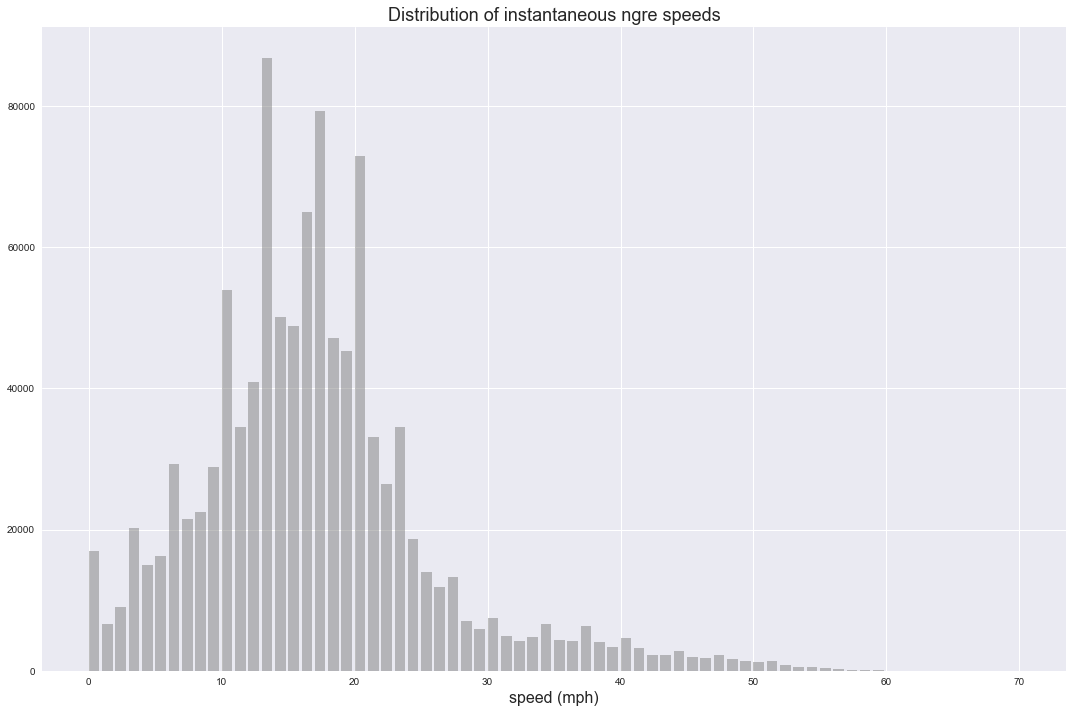

In [20]:
fig, ax =plt.subplots(figsize=(15,10))

ng.vehSpeed.hist(ax=ax, bins=np.arange(0,71,1), figsize=(15,10), 
                      width=0.8, color='grey', alpha=0.5)
ax.set_title("Distribution of instantaneous ngre speeds",fontsize=18)
ax.set_xlabel("speed (mph)",fontsize=16)
fig.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "ngRe inst speeds.png"))

In [21]:
describe(ng.vehAcceleration)

stats
count  1055801.0
NA           0.0
mean        -0.1
std          3.2
min        -46.5
ptc5        -5.7
pct25       -1.3
pct50        0.0
ptc75        1.3
pct95        5.5
max         25.3

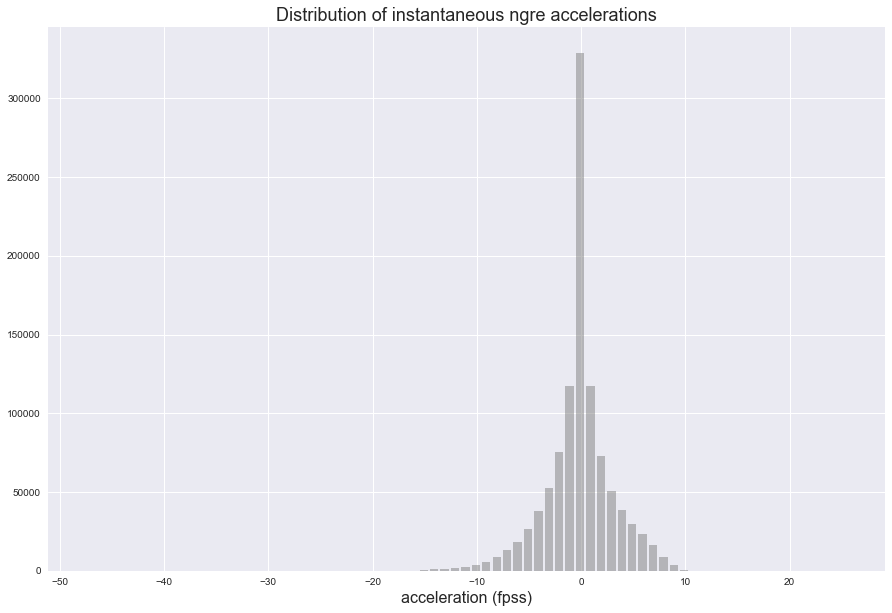

In [22]:
ax = ng.vehAcceleration.hist(bins=np.arange(-47.5,26.5,1), figsize=(15,10), 
                      width=0.8, color='grey', alpha=0.5)
ax.set_title("Distribution of instantaneous ngre accelerations",fontsize=18)
ax.set_xlabel("acceleration (fpss)",fontsize=16)

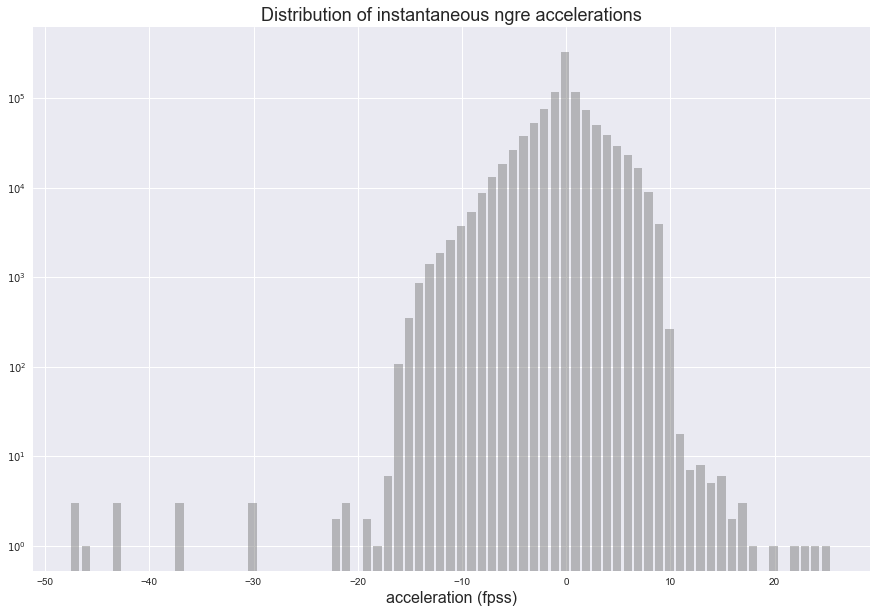

In [23]:
ax = ng.vehAcceleration.hist(bins=np.arange(-47.5,26.5,1), figsize=(15,10), 
                      width=0.8, color='grey', alpha=0.5, log=True)
ax.set_title("Distribution of instantaneous ngre accelerations",fontsize=18)
ax.set_xlabel("acceleration (fpss)",fontsize=16)

In [24]:
tmp1 = (ng.groupby('VehID')[['FrameID', 'locY']]
        
        .first().reset_index()
        .rename(columns={'FrameID':'start', 'locY':'startDist'})
       )
tmp2 = (ng.groupby('VehID')[['FrameID', 'locY']]
        .last()
        .reset_index()
        .rename(columns={'FrameID':'end', 'locY':'endDist'})
       )
    
ng_times = pd.merge(tmp1, tmp2, on=['VehID'])
#ai_times
ng_times['dur'] = (ng_times.end - ng_times.start) / 10.0
ng_times['dist'] = ng_times.endDist - ng_times.startDist 
ng_times['speed'] = (ng_times.dist / 5280.0) / (ng_times.dur / 3600.0)
#ai_times['dur']
ng_times.head()

VehID  start   startDist  end      endDist   dur         dist      speed
0      1    147  164.314797  834  1475.358793  68.7  1311.043996  13.011552
1      2    444  166.107972  728  1469.200755  28.4  1303.092782  31.284238
2      4    217  164.135761  818  1475.407907  60.1  1311.272146  14.876026
3      5    178  165.740945  793  1473.520866  61.5  1307.779921  14.498669
4      7    194  165.435925  812  1473.863386  61.8  1308.427461  14.435431

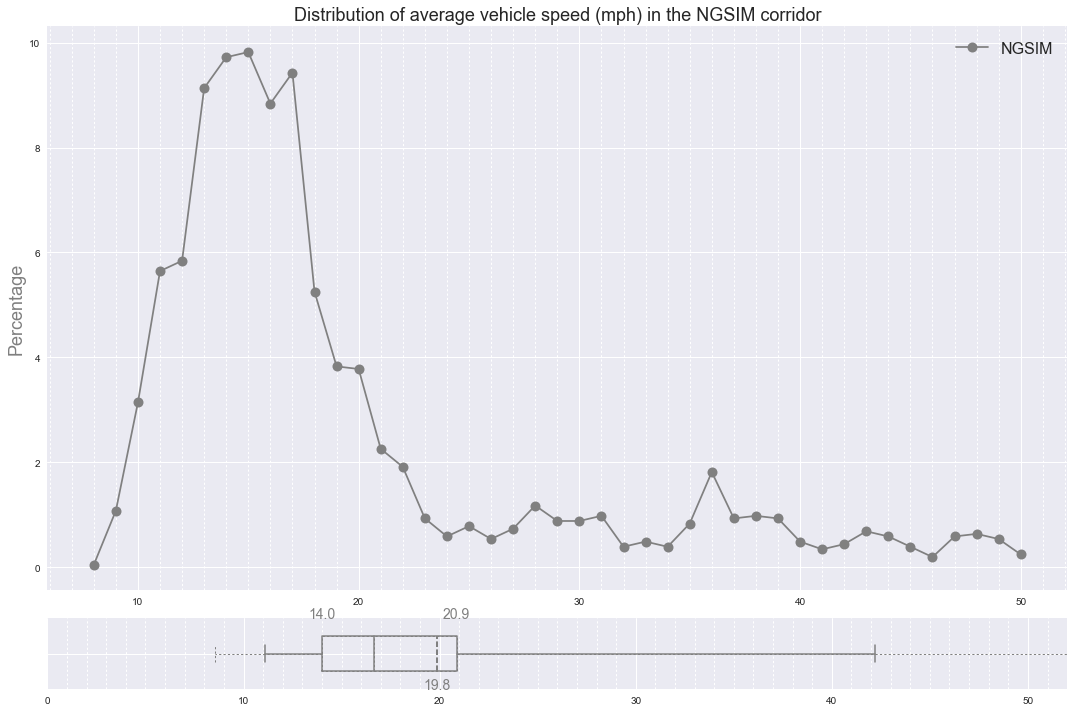

In [25]:
#plt.figure(figsize=(8.5 * 2,11 * 2))
fig = plt.figure(figsize=(15,10))

gs = mpl.gridspec.GridSpec(2, 1,height_ratios=[8, 1])

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])


matplotlibCharts.plotSingleHistLine(ax1, ng_times, 'speed', np.arange(0,52,1), lineParams={'label':'NGSIM', 'color':'grey'})

ax1.legend(fontsize=16)

minor_locator = mpl.ticker.AutoMinorLocator(10)
ax1.xaxis.set_minor_locator(minor_locator)

ax1.grid(b=True, which='major', color='white', lw=1)
ax1.grid(b=True, which='minor', color='white', linestyle="dotted", alpha=1.0)
        
matplotlibCharts.myBoxPlot(ax2, ng_times, 'speed', 'grey', 
            10, axis_min=0, axis_max=52, mean_horizontal_label_shift=0.5)

ax1.set_title("Distribution of average vehicle speed (mph) in the NGSIM corridor", fontsize=18)
ax1.set_ylabel('Percentage', color='grey', fontsize=18)

fig.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "ngRe average veh speeds.png"))

In [26]:
ng.groupby(['lane'])['vehSpeed'].mean()

lane
1      37.215943
2      15.904848
3      15.789959
4      14.249430
5      15.697806
6      15.430255
7      14.191037
999    24.072448
Name: vehSpeed, dtype: float64

## Bining for Heatmap and Traffic Flow calculations

In [103]:
LCR_TIME_BIN = 10 # seconds 
LCR_SPACE_BIN = 50 # in feet


ng['spacebin'] = np.array(ng.locY // LCR_SPACE_BIN, np.int)
ng['timebin'] = pd.to_datetime(((ng.time.astype(np.int64) // 
                                 (LCR_TIME_BIN * 1e9) ) * (LCR_TIME_BIN * 1e9) ))


ng_speed_hm = (ng.groupby(['lane', 'spacebin', 'timebin'])['vehSpeed']
                   .mean() )

ng_speed_hm = (ng_speed_hm.to_frame()
                          .reset_index()
                          .rename(columns={'lane':'laneIndex', 'speedmph':'speed'}) ) 

mi = pd.MultiIndex.from_product([sorted(ng.lane.unique()), 
                                 sorted(ng.spacebin.unique()), 
                                 ng.timebin.unique()], 
                                 names=['laneIndex', 'spacebin', 'timebin'])
mi = pd.DataFrame(index=mi)
mi.reset_index(inplace=True)


ng_speed_hm = ng_speed_hm.merge(mi, on=['laneIndex', 'spacebin', 'timebin'], how='right')
ng_speed_hm = ng_speed_hm.set_index(['laneIndex', 'spacebin', 'timebin']).unstack()

ng_speed_hm = ng_speed_hm.sort_index(level=[0,1], ascending=[True, True])
ng_speed_hm.head(10)

vehSpeed                      \
timebin            2005-04-13 16:00:00 2005-04-13 16:00:10   
laneIndex spacebin                                           
1         3                        NaN                 NaN   
          4                        NaN                 NaN   
          5                        NaN                 NaN   
          6                        NaN                 NaN   
          7                        NaN                 NaN   
          8                        NaN                 NaN   
          9                        NaN                 NaN   
          10                       NaN                 NaN   
          11                       NaN                 NaN   
          12                       NaN                 NaN   

                                                            \
timebin            2005-04-13 16:00:20 2005-04-13 16:00:30   
laneIndex spacebin                                           
1         3                  15.694905            7.603087   
          4                   5.583629            3.925518   
          5                        NaN            6.496721   
          6                        NaN           14.334621   
          7                        NaN                 NaN   
          8                        NaN                 NaN   
          9                        NaN                 NaN   
          10                       NaN                 NaN   
          11                       NaN                 NaN   
          12                       NaN                 NaN   

                                                            \
timebin            2005-04-13 16:00:40 2005-04-13 16:00:50   
laneIndex spacebin                                           
1         3                  17.717279           22.471194   
          4                  16.090492           23.246757   
          5                  17.026541           19.615612   
          6                  18.728009           21.533464   
          7                  21.018297           23.949372   
          8                  23.439414           24.206478   
          9                  26.433581           24.623931   
          10                 25.691383           25.489294   
          11                 22.667007           26.861970   
          12                       NaN           27.484814   

                                                            \
timebin            2005-04-13 16:01:00 2005-04-13 16:01:10   
laneIndex spacebin                                           
1         3                  24.825608           28.860669   
          4                  24.200352           30.610590   
          5                  24.155072           29.086670   
          6                  22.692430           25.289107   
          7                  22.719509           24.382895   
          8                  22.949513           23.729964   
          9                  23.671202           23.416882   
          10                 24.429576           23.124013   
          11                 26.916717           23.680185   
          12                 28.577260           25.045149   

                                                            \
timebin            2005-04-13 16:01:20 2005-04-13 16:01:30   
laneIndex spacebin                                           
1         3                  33.841433           31.537314   
          4                  30.360120           32.034220   
          5                  26.365022           24.484140   
          6                  25.686962           24.565446   
          7                  24.772310           23.252941   
          8                  23.727252           21.750926   
          9                  23.369291           22.392428   
          10                 22.575278           22.263674   
          11                 23.471074           21.708796   
          12                 25.076600           22.163413

In [30]:
ng_hm = (ng.groupby(['lane', 'spacebin', 'timebin'])['vehSpeed']
                  .aggregate([np.mean, np.size]))

ng_hm = (ng_hm.reset_index()
              .rename(columns={'size':'density', 'mean':'speed', 'lane':'laneIndex'}) ) 

mi = pd.MultiIndex.from_product([sorted(ng.lane.unique()), 
                                 sorted(ng.spacebin.unique()), 
                                 ng.timebin.unique()], 
                                 names=['laneIndex', 'spacebin', 'timebin'])
mi = pd.DataFrame(index=mi)
mi.reset_index(inplace=True)
#
#
ng_hm = ng_hm.merge(mi, on=['laneIndex', 'spacebin', 'timebin'], how='right')
ng_hm = ng_hm.set_index(['laneIndex', 'spacebin', 'timebin'])


### the simulation time step is 0.1 seconds this is why I am multiplying by 10 below 
ng_hm['density'] = ng_hm['density'] * (5280 / LCR_SPACE_BIN) / (LCR_TIME_BIN * 10)

In [31]:
ng_hm.head()

speed  density
laneIndex spacebin timebin                                
1         3        2005-04-13 16:00:20  15.694905   15.840
                   2005-04-13 16:00:30   7.603087   16.896
                   2005-04-13 16:00:40  17.717279   36.960
                   2005-04-13 16:00:50  22.471194   46.464
                   2005-04-13 16:01:00  24.825608   32.736

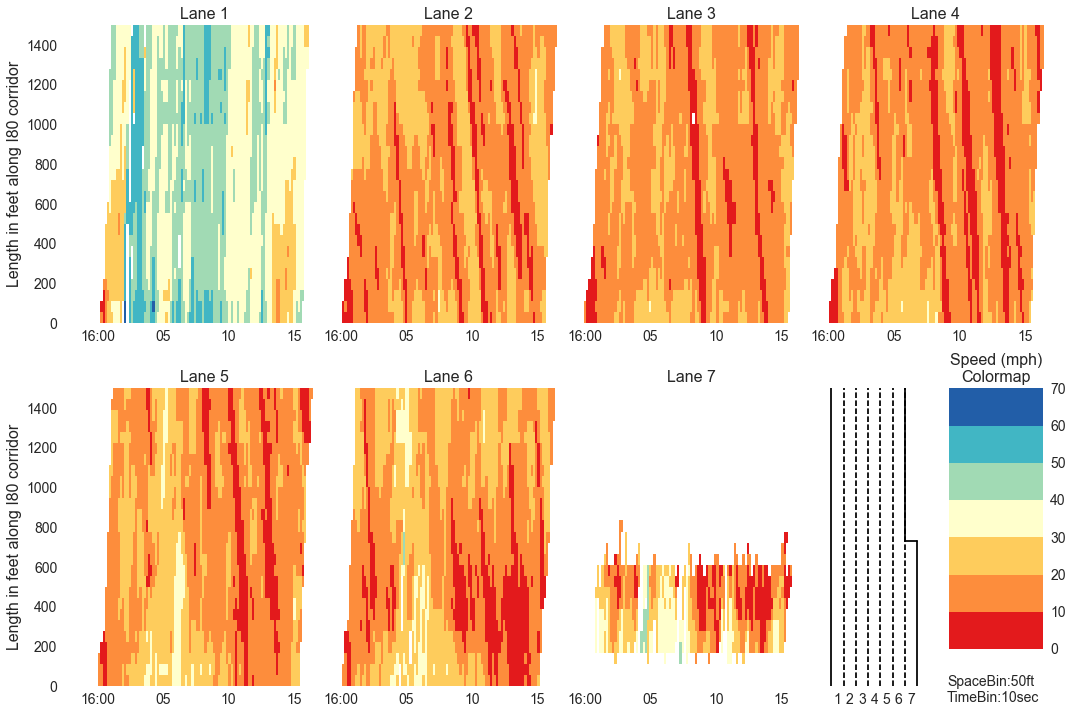

In [104]:
fig = plt.figure(figsize=(15,10))
gs = mpl.gridspec.GridSpec(2, 9, 
        width_ratios=[0.05, 1, 1, 1, 1, 1, 1, 1, 1])

ax_milepost1 = fig.add_subplot(gs[0,0])
ax_l1 = fig.add_subplot(gs[0,1:3])
ax_l2 = fig.add_subplot(gs[0,3:5])
ax_l3 = fig.add_subplot(gs[0,5:7])
ax_l4 = fig.add_subplot(gs[0,7:])

ax_milepost2 = fig.add_subplot(gs[1,0])
ax_l5 = fig.add_subplot(gs[1,1:3])
ax_l6 = fig.add_subplot(gs[1,3:5])
ax_l7 = fig.add_subplot(gs[1,5:7])
ax_schema = fig.add_subplot(gs[1,7])
ax_colormap = fig.add_subplot(gs[1,8])

ax_lanes = [ax_l1, ax_l2, ax_l3, ax_l4, ax_l5, ax_l6, ax_l7]


bounds = [-10, 0, 10, 20, 30, 40, 50, 60, 70]

colors2 = ['white', '#e31a1c','#fd8d3c', '#fecc5c','#ffffcc','#a1dab4','#41b6c4','#225ea8']

cmap = mpl.colors.ListedColormap(colors2) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb = None 
ax = None

HEATMAP_Y_LENGTH = 1501

for i in range(1, 8):
    
    ax = ax_lanes[i-1]
    
    nan_mask = np.isnan(ng_speed_hm.loc[i].values)
    tmp = ng_speed_hm.loc[i].values.copy()
    tmp[nan_mask] = -1

    cb = ax.imshow(tmp, cmap=cmap, norm=norm, origin='lower', aspect='auto')
    
    ax.set_title("Lane %d" % i, fontsize=16)
    
    dtmin = (ng.time.max() - ng.time.min()).total_seconds() / 60
    scale =  ng_speed_hm.shape[1] / dtmin # (ticks per minute )
    x_ticks_replace = scale * np.arange(0, dtmin, 5) 
    ax.set_xticks(x_ticks_replace)
    #ax.set_xticklabels(np.arange(0, int(dtmin), 5)) 
    ax.set_xticklabels(["16:00", "05", "10", "15", ""])
    
    #ax.set_ylim([-0.5, int(HEATMAP_Y_LENGTH / LCR_SPACE_BIN) + 0.5] )
    #y_ticks_replace = np.arange(0, HEATMAP_Y_LENGTH, 200)/LCR_SPACE_BIN - 0.5
    
    #ax.set_yticks(y_ticks_replace) 
    
    #ax.set_yticks(np.arange(-0.5, ng.spacebin.max() + 0.5, 2))
    
    #ax.grid(True, color='black', ls='dashed', lw=0.3)
    
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_facecolor('white')
    

ytick_labels = [i for i in range(0,HEATMAP_Y_LENGTH,200)]
ax_milepost1.set_ylim([0, HEATMAP_Y_LENGTH])
ax_milepost1.set_yticks(ytick_labels)
ax_milepost1.set_yticklabels(ytick_labels)
ax_milepost1.set_xticklabels([])
ax_milepost1.grid(False)
ax_milepost1.set_ylabel("Length in feet along I80 corridor", fontsize=16)
ax_milepost1.set_facecolor('white')


ax_milepost2.set_yticks(ytick_labels)
ax_milepost2.set_ylim([0, HEATMAP_Y_LENGTH])
ax_milepost2.set_yticklabels(ytick_labels)
ax_milepost2.set_xticklabels([])
ax_milepost2.grid(False)
ax_milepost2.set_ylabel("Length in feet along I80 corridor", fontsize=16)
ax_milepost2.set_facecolor('white')

mpl.colorbar.ColorbarBase(ax=ax_colormap, cmap=cmap, norm=norm, boundaries=bounds) 

#fig.colorbar(cb, cax=ax_colormap, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
ax_colormap.set_title("Speed (mph)\nColormap", fontsize=16)
cm_yticklabels = ['', '0', '10', '20', '30', '40', '50', '60', '70']
ax_colormap.set_yticklabels(cm_yticklabels)


dy=10
ax_schema.plot([0,0], [0, 1790], color='black')
ax_schema.plot([dy,dy], [0, 1790], color='black', ls='dashed')
ax_schema.plot([2*dy,2*dy], [0, 1790], color='black',ls='dashed')
ax_schema.plot([3*dy,3*dy], [0, 1790], color='black', ls='dashed')
ax_schema.plot([4*dy,4*dy], [0, 1790], color='black', ls='dashed')
ax_schema.plot([5*dy,5*dy], [0, 1790], color='black', ls='dashed')
ax_schema.plot([6*dy,6*dy], [0, 1790], color='black', ls='dashed')
ax_schema.plot([6*dy,6*dy], [730, 1790], color='black')
ax_schema.plot([7*dy,7*dy], [0, 730], color='black')
ax_schema.plot([6*dy,7*dy], [730, 730], color='black')

ax_schema.set_ylim([0,HEATMAP_Y_LENGTH])
ax_schema.set_yticklabels([])
#ax_schema.set_xticklabels([])

ax_schema.set_xticks([dy/2 + i*dy for i in range(0,7)])
ax_schema.set_xticklabels([i for i in range(1,8)])

ax_schema.set_facecolor('white')
ax_schema.grid(False)

fig.tight_layout()
fig.text(0.88, 0.02, "SpaceBin:%dft\nTimeBin:%dsec" % 
          (LCR_SPACE_BIN, LCR_TIME_BIN), fontsize=14)

fig.savefig(os.path.join(OUT_FOLDER, "ngRe speed heatmap time bin %d space bin %d.png" % (LCR_TIME_BIN, LCR_SPACE_BIN)), dpi=150)

## Trajectories 

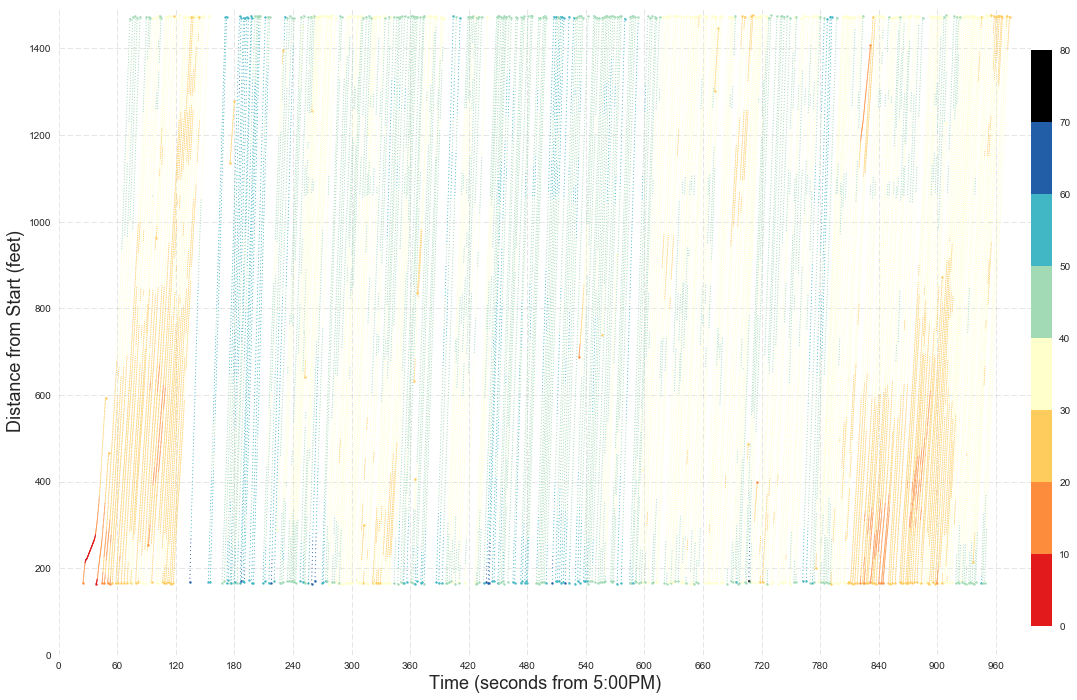

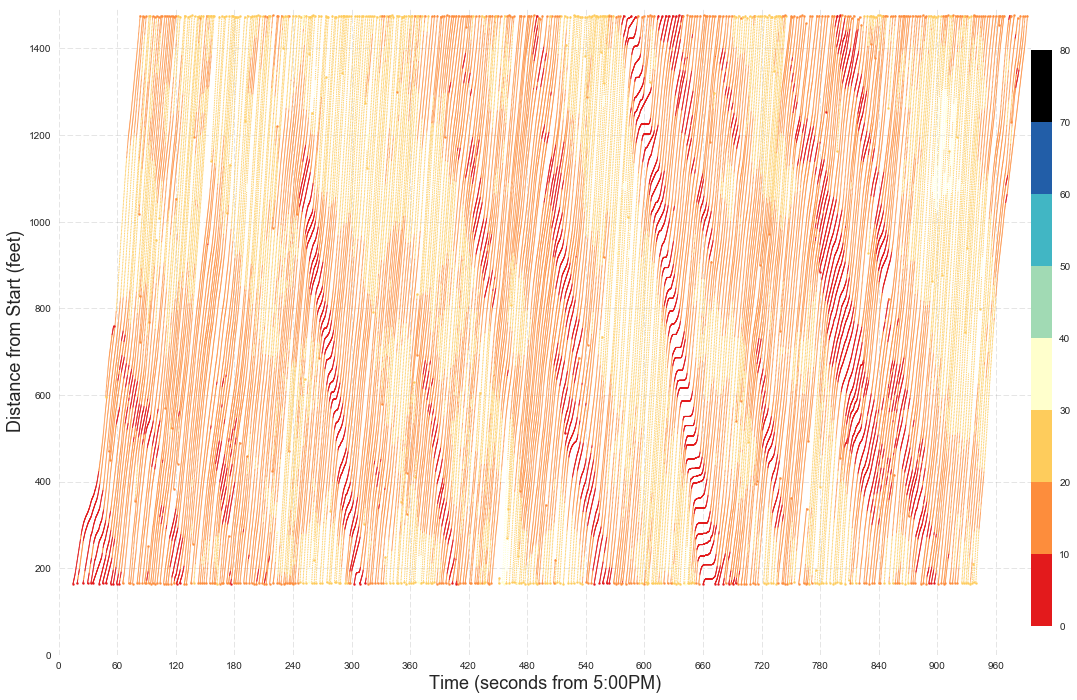

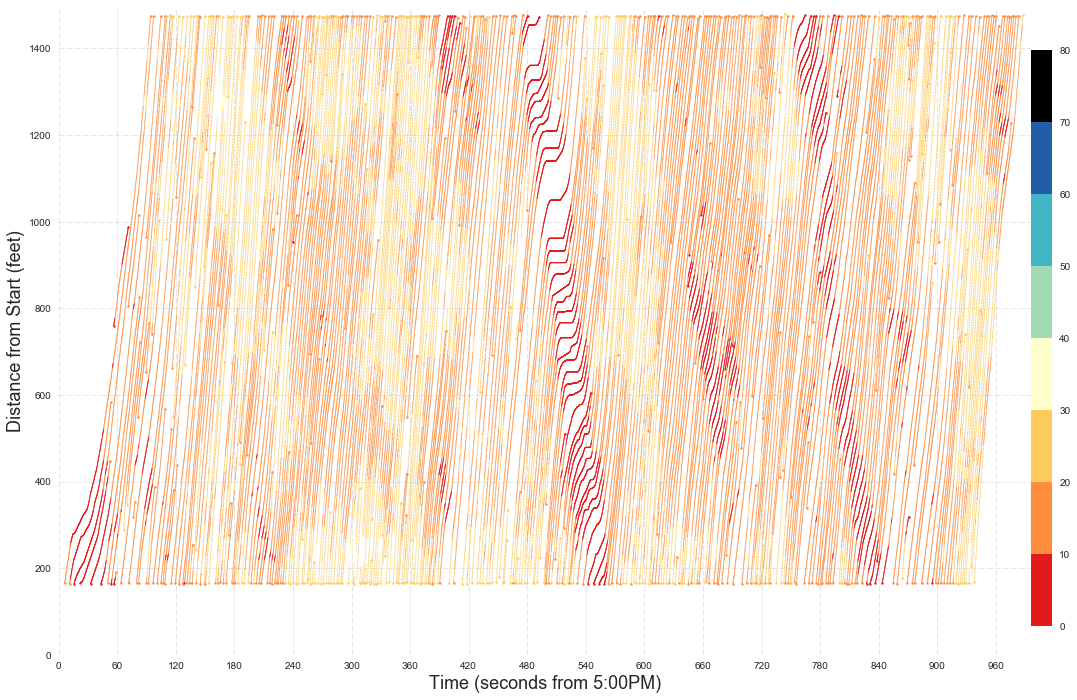

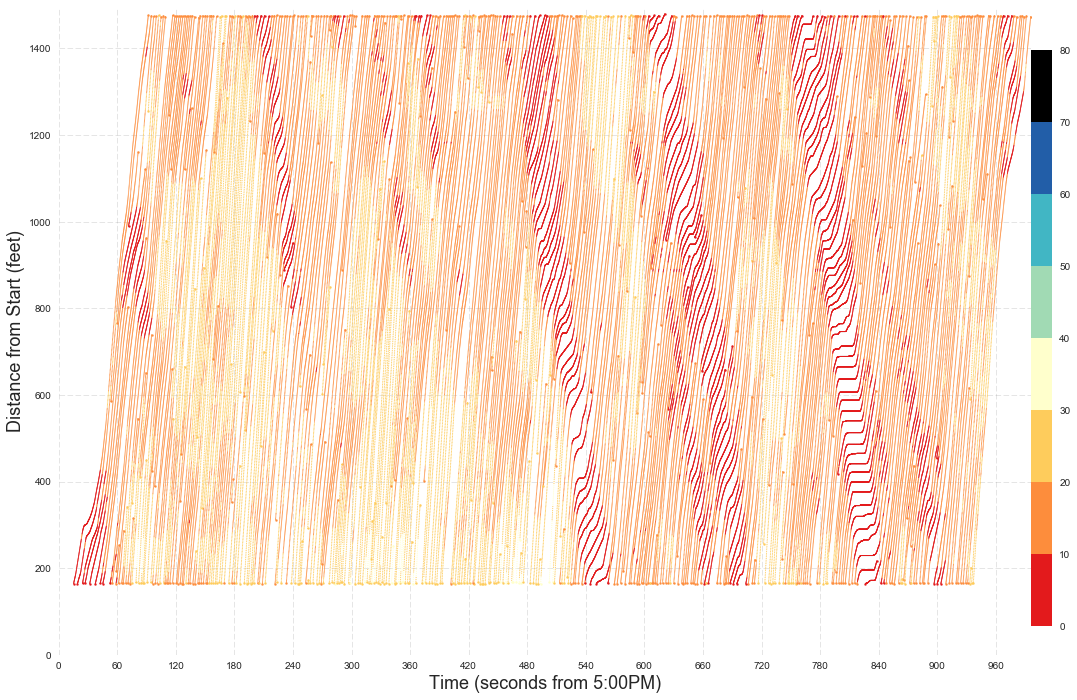

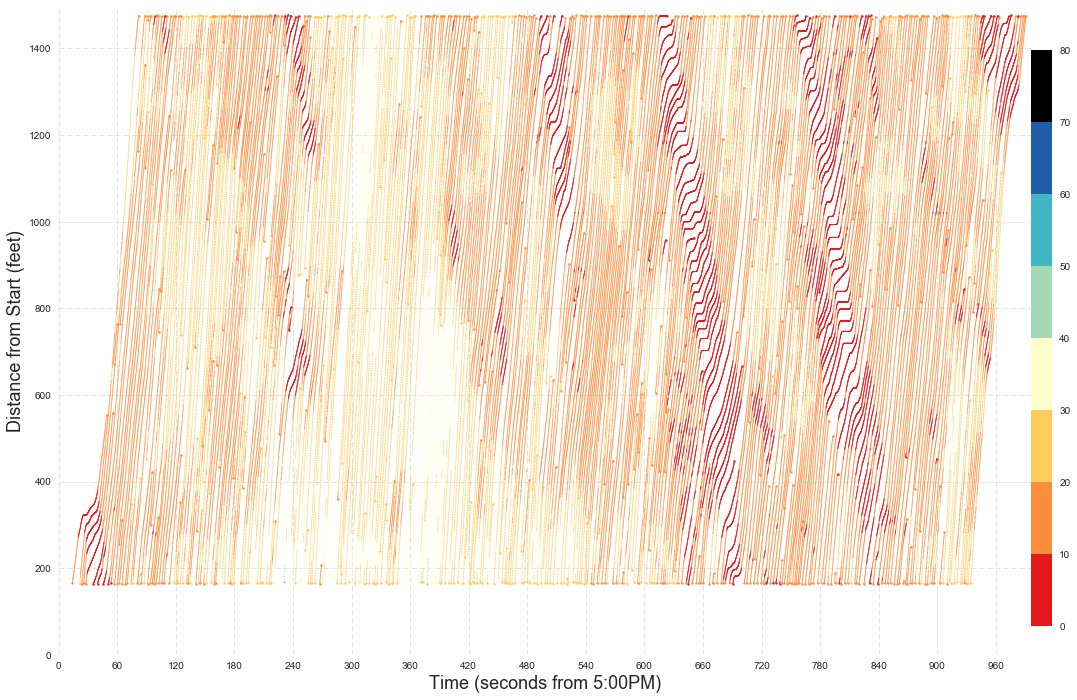

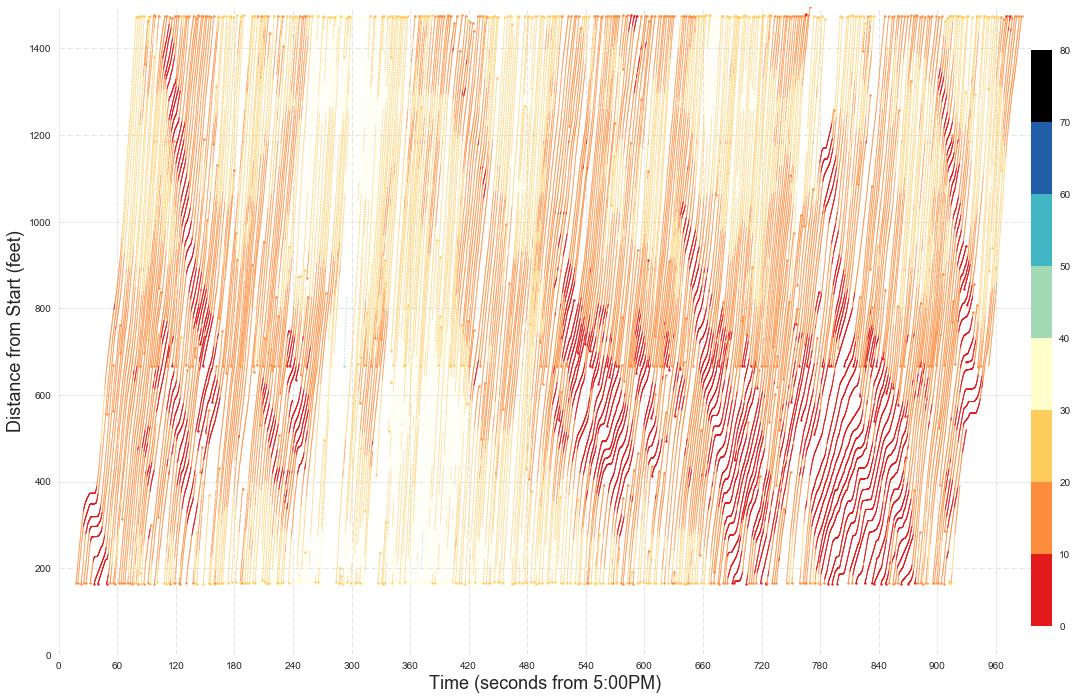

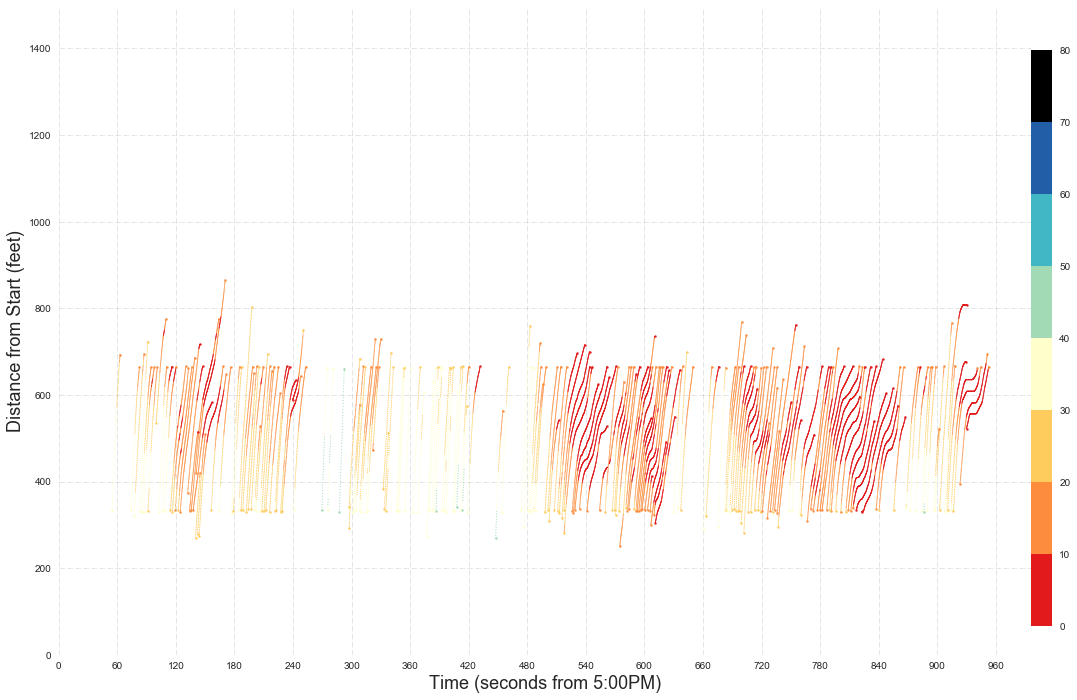

In [33]:

for lane in [1,2,3,4,5,6,7]:
    
    fig = plt.figure(figsize=(15,10))
    #fig, ax = plt.subplots(figsize=(15,10), dpi=150)

    rect = 0.06,0.06,0.90,0.9
    ax = fig.add_axes(rect)
    #fig.add_axes(rect, frameon=False, facecolor='white')
    fig.add_axes(ax)

    bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80]
    colors2 = ['#e31a1c','#fd8d3c', '#fecc5c','#ffffcc','#a1dab4','#41b6c4','#225ea8', '#000000']
    cmap = mpl.colors.ListedColormap(colors2) 
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    group = None 
    for newVehId, group in ng.set_index('lane').loc[lane].groupby('VehID'):
    #for newVehId, group in tmp.groupby('newVehID'):

        colors = group.vehSpeed.apply(lambda spd: 
                                      colors2[int(spd // 10)]).values

        times = group.FrameID.values / 10
        #times = (group.time.values - START_TIME).astype('int') / 1e9
        #locations = group.dist_along.values
        locations = group.locY.values 
        #colors= group.color.values


        ax.scatter(times, locations, c=colors, s=0.5)
        ax.scatter(times[0],   locations[0],   c=colors[0], s=4)
        ax.scatter(times[-1], locations[-1], c=colors[-1], s=4)

    ax.set_facecolor('white')
    ax.set_xlabel("Time (seconds from 5:00PM)",fontsize=18)
    ax.set_ylabel("Distance from Start (feet)", fontsize=18)

    cmax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
    mpl.colorbar.ColorbarBase(ax=cmax, cmap=cmap, norm=norm, boundaries=bounds) 

    majorLocator = MultipleLocator(60)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)

    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_minor_locator(minorLocator)

    #max_time_sec = np.max((ng.time - START_TIME).astype('int') / 1e9)

    ax.set_xlim([0, np.max(ng.FrameID/10)])
    ax.set_ylim([0, ng.locY.max()])

    ax.set_axisbelow(True)
    ax.grid(color='grey', lw=1, linestyle='dashed', alpha=0.2)

 
    fig.savefig(os.path.join(OUT_FOLDER, "ngRe traj lane %d.png" % lane), dpi=150)
    #break 

In [34]:
ng_hm.head()

speed  density
laneIndex spacebin timebin                                
1         3        2005-04-13 16:00:20  15.694905   15.840
                   2005-04-13 16:00:30   7.603087   16.896
                   2005-04-13 16:00:40  17.717279   36.960
                   2005-04-13 16:00:50  22.471194   46.464
                   2005-04-13 16:01:00  24.825608   32.736

In [35]:
ng_hm_mean = (ng_hm.groupby(ng_hm.density.values // 5 * 5)['speed'].aggregate([np.mean, np.size])
                      .reset_index()
                      .rename(columns={'index':'density', 'mean':'mean_speed'}))

ng_hm_mean.head(20)

C:\Anaconda\envs\py34\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in floor_divide
  if __name__ == '__main__':


density  mean_speed   size
0       0.0   29.368134   77.0
1       5.0   37.557907  194.0
2      10.0   36.420469  275.0
3      15.0   33.971842  222.0
4      20.0   35.437591  406.0
5      25.0   32.958860  528.0
6      30.0   32.287687  669.0
7      35.0   30.477303  626.0
8      40.0   27.245227  793.0
9      45.0   25.400166  750.0
10     50.0   22.598368  810.0
11     55.0   21.420759  666.0
12     60.0   20.947387  849.0
13     65.0   19.852684  902.0
14     70.0   18.747051  970.0
15     75.0   17.784025  750.0
16     80.0   17.358372  889.0
17     85.0   16.450832  840.0
18     90.0   15.537189  602.0
19     95.0   14.842434  641.0

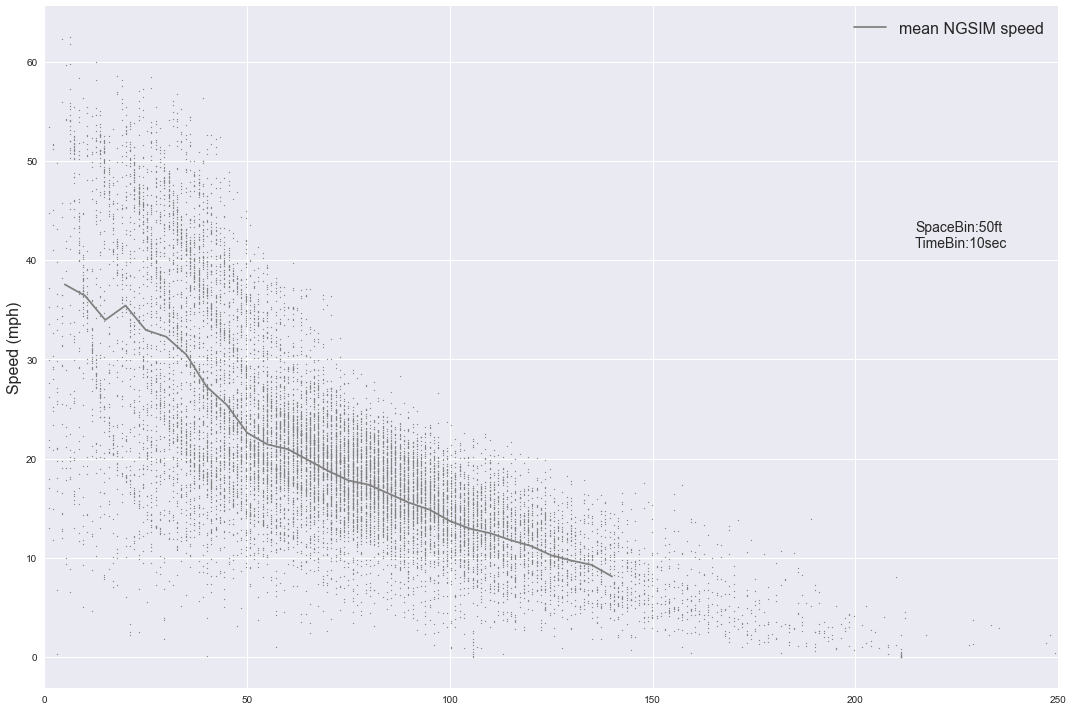

In [36]:
fig, ax1 = plt.subplots(figsize=(15,10))

grey_points = ax1.scatter(ng_hm.density, ng_hm.speed, s=1, color='grey', label=None)

ax1.set_xlim([0,250])
tmp = ng_hm_mean[ng_hm_mean['size'] > 100]
mean_line = ax1.plot(tmp.density, tmp.mean_speed, c='grey', label="mean NGSIM speed")
ax1.legend(fontsize=16)

ax1.legend(fontsize=16)

ax1.set_ylabel("Speed (mph)", fontsize=16)
ax2.set_xlabel('Density (vpm)', fontsize=16)

#ax1.set_title("ngRe Data", fontsize=18)
#fig.legend(handles=[grey_points, blue_points], labels=['NGSIM', "Model"], fontsize=18)
fig.text(0.85, 0.65, "SpaceBin:%dft\nTimeBin:%dsec" % (LCR_SPACE_BIN, LCR_TIME_BIN), fontsize=14)

fig.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, "ngRe density vs speed all.png"))

C:\Anaconda\envs\py34\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in floor_divide


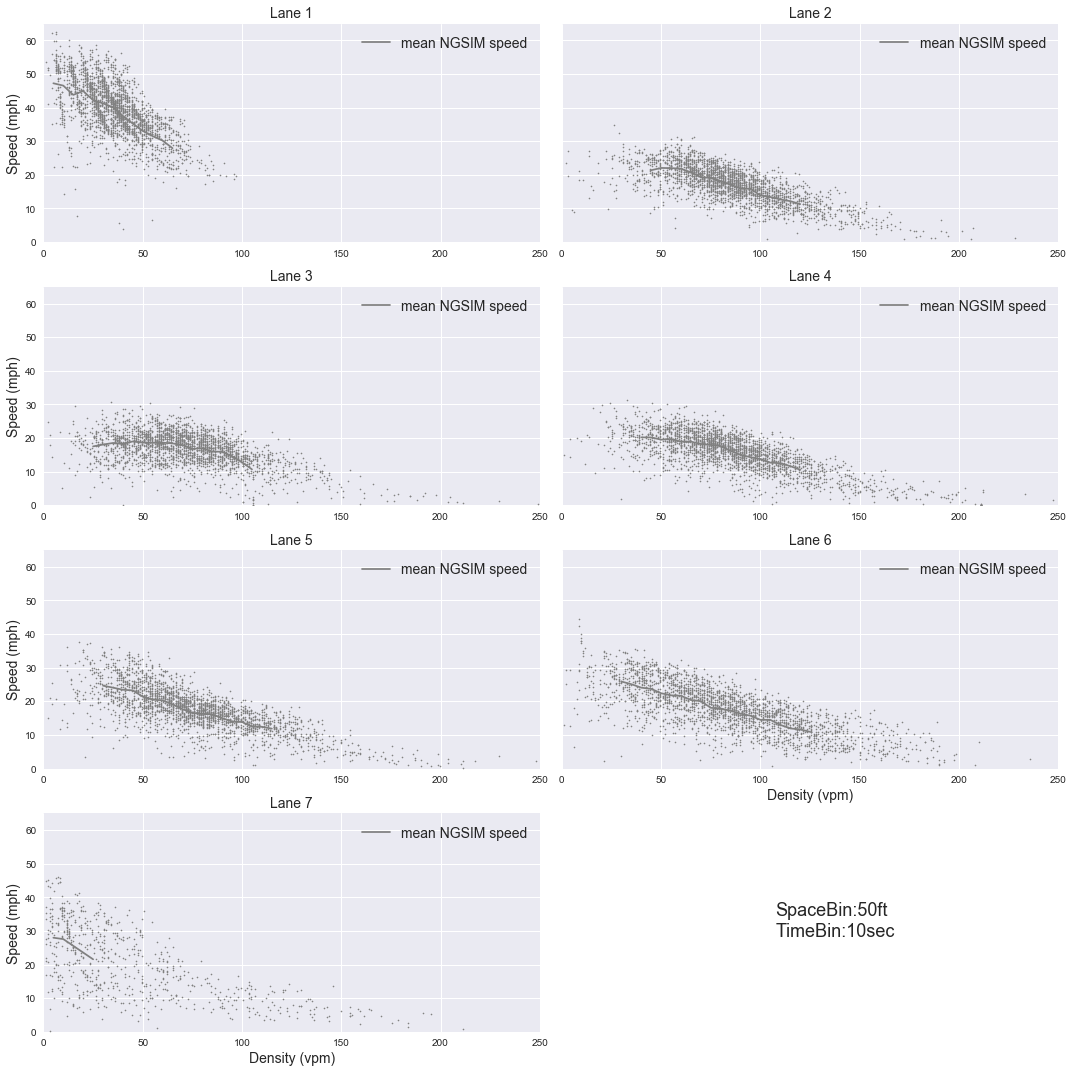

In [37]:
fig = plt.figure(figsize=(15, 15))

gs = mpl.gridspec.GridSpec(4, 2)

for laneNum in range(1, 8):
    
    i = (laneNum - 1) // 2
    j = (laneNum - 1) % 2 
    
    ax = plt.subplot(gs[i,j])
    
    tmp = ng_hm.loc[laneNum]
    
    
    ax.scatter(tmp.density, tmp.speed, s=1.5, color='grey', label=None)
    ax.set_xlim([0,250])
    ax.set_ylim([0,65])
    ax.set_title("Lane %d" % laneNum, fontsize=14)
    
    tmp_mean = (tmp.groupby(tmp.density.values // 5 * 5)['speed']
                      .aggregate([np.mean, np.size])
                      .reset_index()
                      .rename(columns={'index':'density', 'mean':'mean_spd'}))
    
    tmp_mean = tmp_mean[tmp_mean['size'] > 50]
    
    ax.plot(tmp_mean.density, tmp_mean.mean_spd, c='grey', label='mean NGSIM speed')
    
    if j == 1:
        ax.set_yticklabels([])
        
    if j == 0:
        ax.set_ylabel("Speed (mph)", fontsize=14)
        
    ax.legend(fontsize=14)

plt.subplot(gs[3,0]).set_xlabel("Density (vpm)", fontsize=14)
plt.subplot(gs[2,1]).set_xlabel("Density (vpm)", fontsize=14)

fig.tight_layout()
fig.text(0.72, 0.13, "SpaceBin:%dft\nTimeBin:%dsec" % (LCR_SPACE_BIN, LCR_TIME_BIN), fontsize=18)
fig.savefig(os.path.join(OUT_FOLDER, "ngRe density vs speed per lane.png"))

<h1> Physical Limits </h1> 

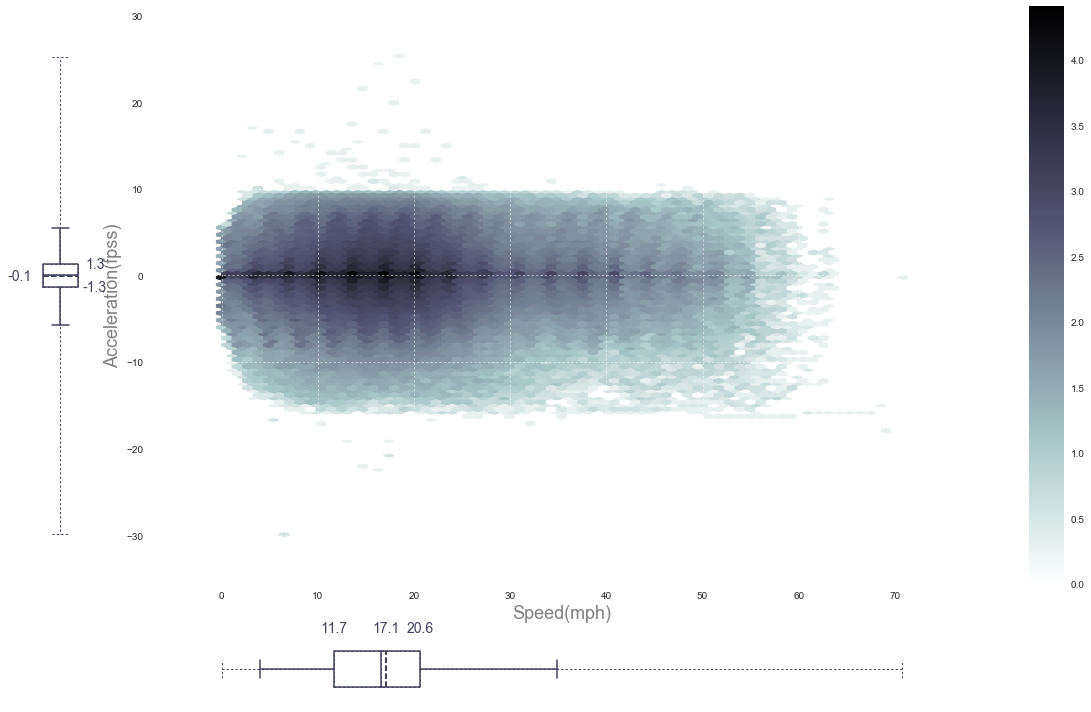

In [38]:
fig = plt.figure(figsize=(15,10))

gs = mpl.gridspec.GridSpec(2, 3, height_ratios=[8, 1], width_ratios=[1, 12, 0.5])

ax2 = plt.subplot(gs[0,1])
ax1 = plt.subplot(gs[0,0])#, sharey=ax2)

ax3 = plt.subplot(gs[0,2])

ax4 = plt.subplot(gs[1,1])#, sharex=ax2)

tmp = ng[ng.vehAcceleration > -32]

cmap = plt.cm.bone_r

gridsize=(65, int((120+15)/2))

cb = ax2.hexbin(tmp.vehSpeed, tmp.vehAcceleration, bins='log', gridsize=gridsize, cmap=cmap)

cbar = fig.colorbar(cb, cax=ax3) # ticks=[1, 10, 100, 1000, 10000])
#cbar.ax.set_yticklabels(['1', '10', '100', '1000', '10000'])  # vertically oriented colorbar
ax2.set_facecolor('white')

xmin, xmax = ax2.get_xlim() 
ymin, ymax = ax2.get_ylim()
#plot horizontal gridlines
for y  in [-30, -20, -10, 0, 10]:
    ax2.plot([xmin, xmax], [y,y], lw=1, color='white', alpha=0.5, ls="dotted")
for x in range(0,70,10):
    ax2.plot([x, x], [ymin, ymax], lw=1, color='white', alpha=0.5, ls="dotted")

#ax2.set_title("Two-Dimensional Distribution of Instantaneous ngRe Acceleration by Speed\nbin size is 1mph by 1fpss", fontsize=18, color='grey')
ax2.set_xlabel("Speed(mph)",fontsize=18, color='grey')
ax2.set_ylabel("Acceleration(fpss)", fontsize=18, color='grey')

plt.setp( ax2.get_xticklabels(), visible=True)


matplotlibCharts.myBoxPlot(ax4, tmp, 'vehSpeed', cmap(0.7))# mean_horizontal_label_shift=0.5)
ax4.set_facecolor('white')
ax4.set_xticklabels([])
ax4.set_xlim(ax2.get_xlim())

matplotlibCharts.myBoxPlot(ax1, tmp, 'vehAcceleration', cmap(0.7), vert=True, mean_vertical_label_shift=0.4)

ax1.set_xticklabels([])
ax1.set_ylim(ax2.get_ylim())
ax1.set_facecolor('white')

fig.tight_layout() 

fig.savefig(os.path.join(OUT_FOLDER, "ngRe instantaneous speed vs accel.png"))


In [39]:
def calculatePercentiles(df, fieldName, grouper):
    
    stats = df.groupby(grouper)[fieldName].agg({'mean': np.mean,
                                               'size': np.size, 
                                               'min': np.min, 
                                               'max': np.max,
                                               'std': np.std, 
                                               'pct5': lambda x:np.percentile(x, 5),
                                               'pct25': lambda x:np.percentile(x, 25),
                                               'pct95': lambda x:np.percentile(x, 95),
                                               'pct75': lambda x:np.percentile(x, 75), 
                                               'pct99': lambda x:np.percentile(x, 99),
                                               'pct1': lambda x:np.percentile(x, 1),
                                               'pct999': lambda x:np.percentile(x, 99.9),
                                               'pct01': lambda x:np.percentile(x, 0.1)                                               
                                              })
    return stats

In [40]:
ng_spd_acc_stats = calculatePercentiles(ng, 'vehAcceleration', 
                                        np.array(ng.vehSpeed, np.int))

In [41]:
mpl.rc('ytick', labelsize=14)
mpl.rc('xtick', labelsize=14)

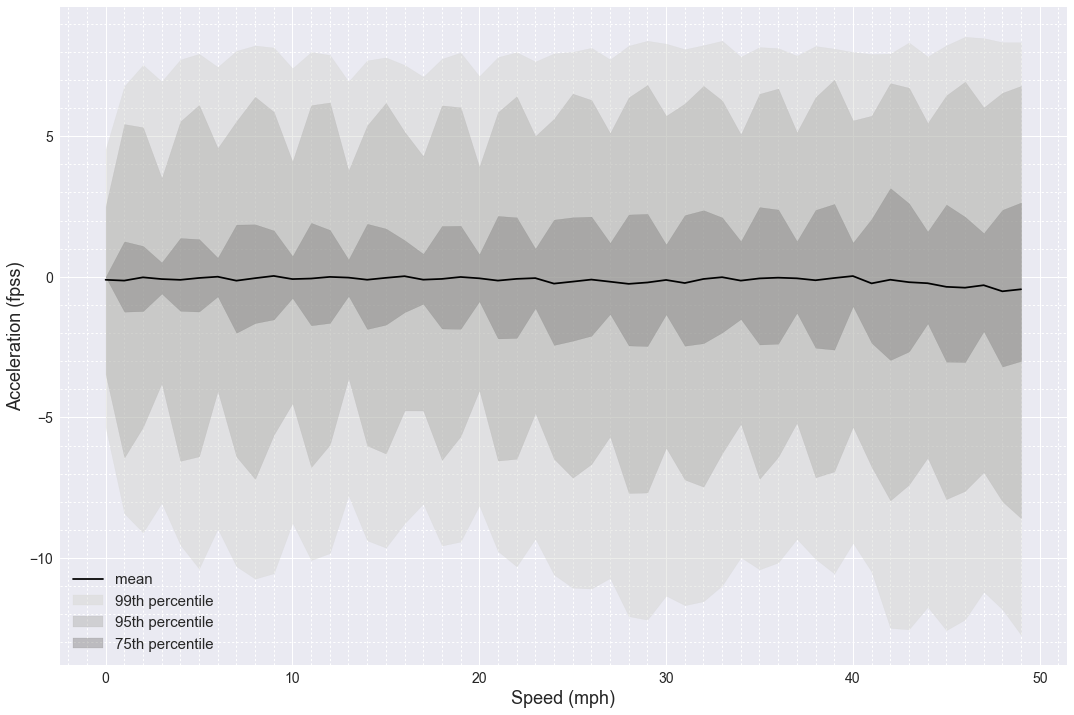

In [42]:
fig, ax = plt.subplots(figsize=(15,10))

df = ng_spd_acc_stats.iloc[:50]
#ax.fill_between(df.index, y1=df.pct999, y2=df.pct01, color = ccolors.t2, alpha=0.9)

ax.fill_between(df.index, y1=df.pct99, y2=df.pct1, color = ccolors.t3,   alpha=0.4, label='99th percentile')
ax.fill_between(df.index, y1=df.pct95, y2=df.pct5, color = ccolors.t5,    alpha=0.4, label='95th percentile')
ax.fill_between(df.index, y1=df.pct75, y2=df.pct25, color = ccolors.t7,   alpha=0.4, label='75th percentile')
ax.plot(df.index, df['mean'], color='k', label='mean')

#ax.set_xlim([0, 60])
xminorLocator = MultipleLocator(1)
yminorLocator = MultipleLocator(1)
ax.yaxis.set_minor_locator(yminorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.grid(b=True, which='minor', color='white', linestyle="dotted", alpha=1.0)

#ax.set_facecolor('white')
#ax.set_facecolor((0.9176470588235294, 0.9176470588235294, 0.9490196078431372, 1.0))

#ax.set_axisbelow(False)

#ax.set_title("Percentile Acceleration Distribution by Speed in the ngRe", fontsize=18)
ax.set_ylabel("Acceleration (fpss)", fontsize=18)
ax.set_xlabel("Speed (mph)", fontsize=18)
ax.legend(loc=3, fontsize=15)

fig.tight_layout() 

fig.savefig(os.path.join(OUT_FOLDER, "ngRe Percentile Acceleration Distribution by Speed.png"))

In [43]:
#H, xedges, yedges = np.histogram2d(ng.vehSpeed, ng.vehAcceleration,
#                                   bins=[np.arange(0, 50,1), np.arange(-16.0,16.0,1)], normed=True)


# NUM_INTERVALS = 10
# bounds = np.arange(0, H.max())
# bounds = np.linspace(0, H.max(), NUM_INTERVALS)
# bounds = list(bounds)
# bounds.insert(0, -1)
# bounds[1] = 0.00001

# colors = [] 
# for i in np.linspace(0, 1, NUM_INTERVALS):
#     c = plt.cm.bone_r(i)
#     colors.append(c)


# fig, ax = plt.subplots(figsize=(15, 10))

# cmap = mpl.colors.ListedColormap(colors) 
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# #ax.hist(H.flat, bins=np.linspace(0, H.max(), 10) , log=True, alpha=0.5)
# ax.imshow(H.T, cmap=cmap)


# #bins=np.arange(0, 0.026, 0.001)
# ax.set_title("hello")

# #import brewer2mpl

# #bmap = brewer2mpl.get_map('Greys', 'Sequential', 9)
# #bmap.hex_colors

# fig, ax = plt.subplots(figsize=(15, 10))

# cmap = mpl.colors.ListedColormap(colors) 
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# #ax.hist(H.flat, bins=np.linspace(0, H.max(), 10) , log=True, alpha=0.5)
# ax.hist2d(ng.vehSpeed, ng.vehAcceleration, 
#                 bins=[np.arange(0, 50,1), np.arange(-16,16,1)], normed=True, 
#                  cmap=cmap)




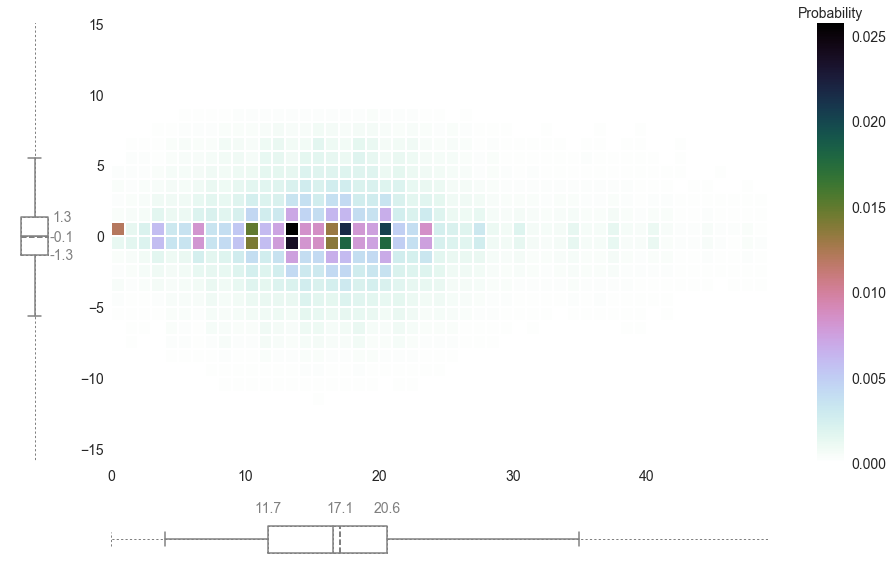

In [44]:
fig = plt.figure(figsize=(15,10))

gs = mpl.gridspec.GridSpec(2, 3, height_ratios=[8, 1], 
                           width_ratios=[1, 12, 0.5])


ax1 = plt.subplot(gs[0,0])#, sharey=ax2)
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,1])#, sharex=ax2)

counts, xedges, yedges, Image = ax2.hist2d(ng.vehSpeed, ng.vehAcceleration, 
          bins=[np.arange(0, 50,1), np.arange(-16,16,1)], normed=True,
         cmap=plt.cm.cubehelix_r)

#minor_locator = mpl.ticker.AutoMinorLocator(1)
#ax1.xaxis.set_minor_locator(minor_locator)

xminorLocator = MultipleLocator(1)
yminorLocator = MultipleLocator(1)
ax2.yaxis.set_minor_locator(yminorLocator)
ax2.xaxis.set_minor_locator(xminorLocator)
ax2.grid(b=True, which='minor', color='white', alpha=1.0)


ax2.grid(b=True, which='major', color='white', lw=2)
ax2.grid(b=True, which='minor', color='white', lw=2, alpha=1.0)


matplotlibCharts.myBoxPlot(ax4, ng, 'vehSpeed', 'grey')# mean_horizontal_label_shift=0.5)
ax4.set_facecolor('white')
ax4.set_xticklabels([])
ax4.set_xlim(ax2.get_xlim())

matplotlibCharts.myBoxPlot(ax1, ng, 'vehAcceleration', 'grey', vert=True)# mean_vertical_label_shift=0.4, vert=True)

ax1.set_xticklabels([])
ax1.set_ylim(ax2.get_ylim())
ax1.set_facecolor('white')

#ax.set_facecolor('grey')
fig.colorbar(Image, cax=ax3)
ax3.set_title("Probability", fontsize=14)
#ax2.set_title("2D Histogram of Instantaneous Speed vs Acceleration", fontsize=18)

fig.savefig(os.path.join(OUT_FOLDER, "ngRe 2D Histogram of Instantaneous Speed vs Acceleration.png"))

<h2> Upsample to 1 second </h2>

In [45]:
ng = ng.sort_values(['VehID', 'time'])
ng.index = np.arange(ng.shape[0])

result = [] 
for VehId, group in ng.groupby('VehID'):
    
    tmp2 = (group[['time', 'vehAcceleration', 'vehSpeed',  'locY']]
           .set_index('time')
           .resample('1s')
           .mean()
           .reset_index()
           )
    
    tmp2['VehID'] = VehId
    
    tmp2['jerk'] = tmp2.vehAcceleration.shift(-1) - tmp2.vehAcceleration
    result.append(tmp2)

ng1s = pd.concat(result)
ng1s = ng1s.merge(ng[['VehID', 'time', 'lane']])
ng1s = ng1s.dropna()

In [46]:
ng1s.head()

time  vehAcceleration  vehSpeed        locY  VehID      jerk  \
0 2005-04-13 16:00:15         0.419465  7.124232  172.043858      1  2.379390   
1 2005-04-13 16:00:16         2.798855  7.828199  182.822871      1 -1.616033   
2 2005-04-13 16:00:17         1.182822  9.772783  196.068770      1 -1.180617   
3 2005-04-13 16:00:18         0.002205  9.896418  210.557060      1 -0.002215   
4 2005-04-13 16:00:19        -0.000010  9.896261  225.068379      1  0.008458   

   lane  
0     2  
1     2  
2     2  
3     2  
4     2

## Vehicle Acceleration 

In [47]:
describe(ng1s.vehAcceleration)

stats
count  103560.0
NA          0.0
mean       -0.1
std         2.6
min       -20.1
ptc5       -4.6
pct25      -1.3
pct50       0.0
ptc75       1.3
pct95       4.3
max        10.7

In [48]:
hist, bins = np.histogram(ng1s.vehAcceleration, np.arange(-21.5, 11.5, 1))

acc_freq = pd.DataFrame(index=bins[:-1], data=hist, columns=['freq'])
labels = ["%.1f <= acc < %.1f" % (i, i+1) for i in bins[:-1]]
acc_freq.index = labels

acc_freq['ngRe_Percentage'] = acc_freq['freq'] / ng1s.shape[0] * 100
acc_freq.to_clipboard()
acc_freq.to_csv(os.path.join(OUT_FOLDER, "ngRe Acceleration.csv"))
acc_freq.head()

freq  ngRe_Percentage
-21.5 <= acc < -20.5     0         0.000000
-20.5 <= acc < -19.5     1         0.000966
-19.5 <= acc < -18.5     0         0.000000
-18.5 <= acc < -17.5     0         0.000000
-17.5 <= acc < -16.5     2         0.001931

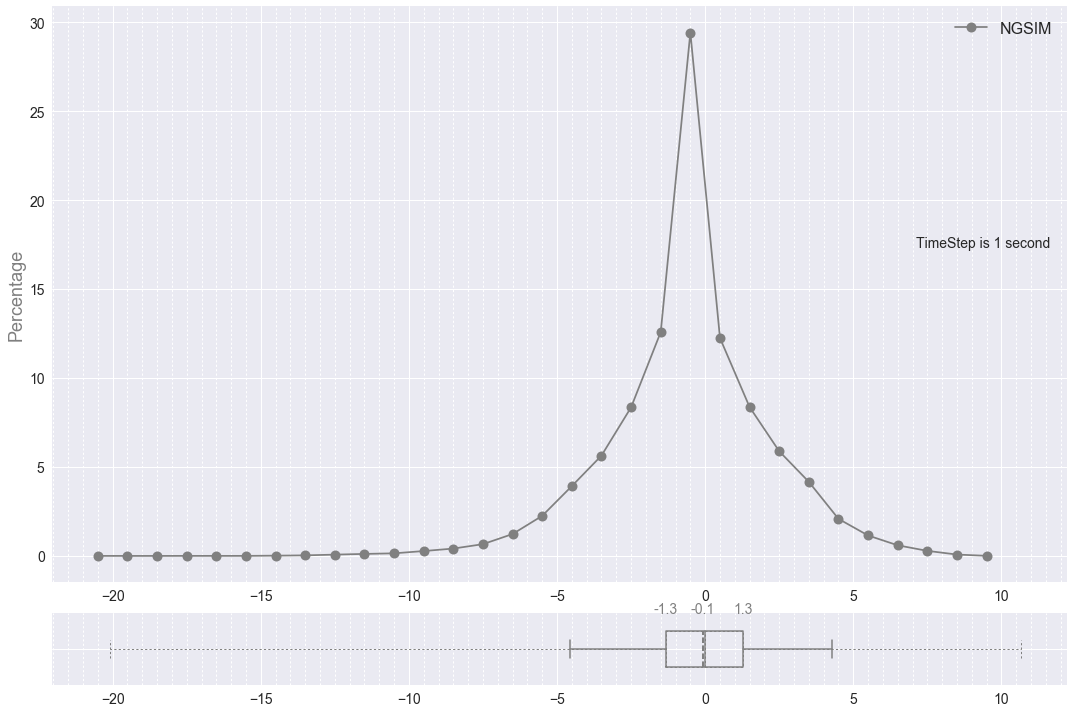

In [49]:
fig = plt.figure(figsize=(15, 10))

gs = mpl.gridspec.GridSpec(2, 1,height_ratios=[8, 1])

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0], sharex=ax1)

matplotlibCharts.plotSingleHistLine(ax1, ng1s, 'vehAcceleration',
            np.arange(-21.5, 11.5, 1), lineParams={'label':'NGSIM', 'color':'grey'})

ax1.legend(fontsize=16)

minor_locator = mpl.ticker.AutoMinorLocator(1)
ax1.xaxis.set_minor_locator(minor_locator)

ax1.grid(b=True, which='major', color='white', lw=1)
ax1.grid(b=True, which='minor', color='white', linestyle="dotted", alpha=1.0)
        
matplotlibCharts.myBoxPlot(ax2, ng1s,  'vehAcceleration','grey', 10) #axis_min=0, axis_max=65)

#ax1.set_title("Distribution of Acceleration Jerk in the NGSIM corridor\nTime step is 1 second", fontsize=18)
ax1.set_ylabel('Percentage', color='grey', fontsize=18)

fig.text(0.85, 0.65, "TimeStep is 1 second", fontsize=14)
fig.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, "ngRe Distribution of Acceleration.png"))

## Acceleration Jerk

In [50]:
describe(ng1s.jerk)

stats
count  103560.0
NA          0.0
mean        0.0
std         3.2
min       -20.5
ptc5       -5.5
pct25      -1.7
pct50       0.0
ptc75       1.8
pct95       5.1
max        16.8

In [51]:
hist, bins = np.histogram(ng1s.jerk, bins=np.arange(-21.5, 17.5, 1))

jerk_freq = pd.DataFrame(index=bins[:-1], data=hist, columns=['freq'])
labels = ["%.1f" % ((i+j)/2) for i,j in zip(bins[:], bins[1:])]
jerk_freq.index = labels

jerk_freq['ngRe_Percentage'] = jerk_freq['freq'] / ng1s.shape[0] * 100
jerk_freq.to_clipboard()
jerk_freq.index.name = 'bin center'
jerk_freq.to_csv(os.path.join(OUT_FOLDER,"ngRe Jerk.csv"))
jerk_freq.head(15)


freq  ngRe_Percentage
bin center                       
-21.0          0         0.000000
-20.0          1         0.000966
-19.0          0         0.000000
-18.0          1         0.000966
-17.0          1         0.000966
-16.0          3         0.002897
-15.0         16         0.015450
-14.0         17         0.016416
-13.0         41         0.039591
-12.0         56         0.054075
-11.0        143         0.138084
-10.0        287         0.277134
-9.0         538         0.519506
-8.0         826         0.797605
-7.0        1282         1.237930

In [52]:
hist, bins = np.histogram(ng1s.jerk, bins=np.array([-200, -50, -15, -3, 3, 15, 50, 200]))

jerk_freq = pd.DataFrame(index=bins[:-1], data=hist, columns=['freq'])
labels = ["%0.f to %0.f" % (i,j) for i,j in zip(bins, bins[1:])]
jerk_freq.index = labels

jerk_freq[' _Percentage'] = jerk_freq['freq'] / ng1s.shape[0] * 100
#jerk_freq.to_clipboard()
jerk_freq.to_csv(os.path.join(OUT_FOLDER, "Jerk.csv"))
jerk_freq

freq   _Percentage
-200 to -50      0      0.000000
-50 to -15      12      0.011587
-15 to -3    15455     14.923716
-3 to 3      72576     70.081112
3 to 15      15505     14.971997
15 to 50        12      0.011587
50 to 200        0      0.000000

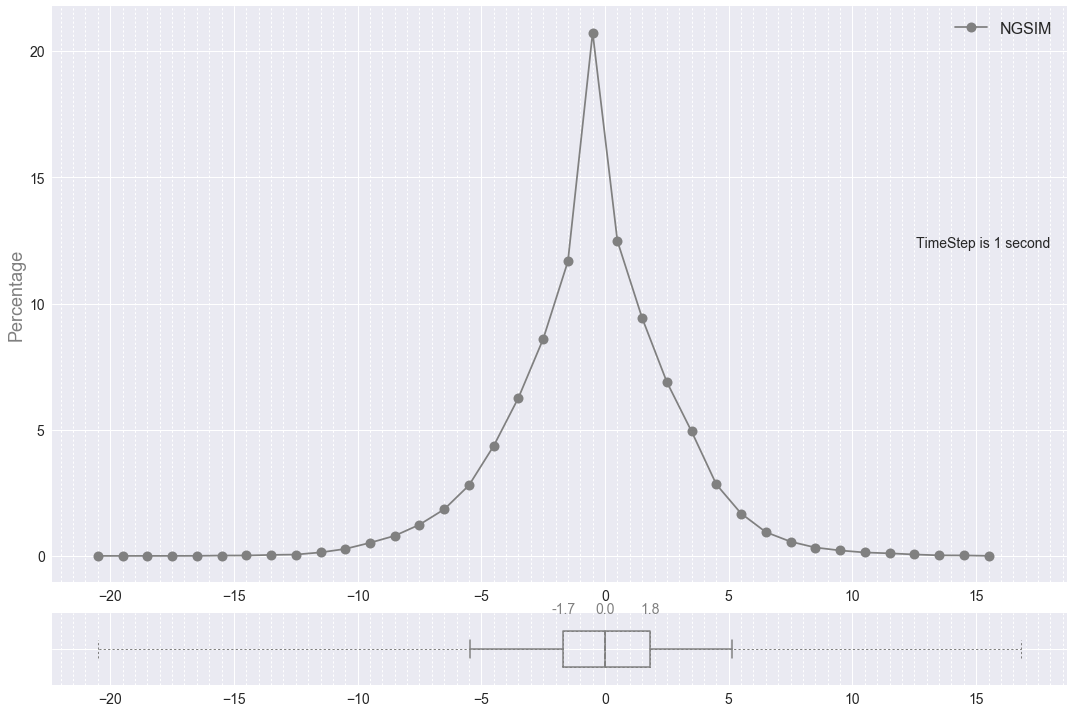

In [53]:
fig = plt.figure(figsize=(15, 10))

gs = mpl.gridspec.GridSpec(2, 1,height_ratios=[8, 1])

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0], sharex=ax1)

matplotlibCharts.plotSingleHistLine(ax1, ng1s, 'jerk',
            np.arange(-21.5, 17.5, 1), lineParams={'label':'NGSIM', 'color':'grey'})

ax1.legend(fontsize=16)

minor_locator = mpl.ticker.AutoMinorLocator(1)
ax1.xaxis.set_minor_locator(minor_locator)

ax1.grid(b=True, which='major', color='white', lw=1)
ax1.grid(b=True, which='minor', color='white', linestyle="dotted", alpha=1.0)
        
matplotlibCharts.myBoxPlot(ax2, ng1s,  'jerk','grey', 10) #axis_min=0, axis_max=65)

#ax1.set_title("Distribution of Acceleration Jerk in the NGSIM corridor\nTime step is 1 second", fontsize=18)
ax1.set_ylabel('Percentage', color='grey', fontsize=18)

fig.tight_layout()
fig.text(0.85, 0.65, "TimeStep is 1 second", fontsize=14)

fig.savefig(os.path.join(OUT_FOLDER, "ngRe Distribution of Acceleration Jerk.png"))


## ARMS

In [54]:
result = [] 

for sbin, group in ng.groupby(np.array(ng.vehSpeed, np.int) // 5 * 5 ):

    arms = np.sqrt(np.sum(group.vehAcceleration.dropna().values ** 2) / group.shape[0]) * 0.303
    

    result.append((sbin, arms, group.shape[0]))
    #break 

arms = pd.DataFrame(result, columns=['speedbin', 'arms', 'n'])

arms.to_csv(os.path.join(OUT_FOLDER, "ngRe ARMS.csv"))

arms.head(10)

speedbin      arms       n
0         0  0.785591   67733
1         5  1.006837  118339
2        10  0.900056  266193
3        15  0.952856  285409
4        20  0.941629  185552
5        25  1.149744   52241
6        30  1.088129   28014
7        35  1.135443   22468
8        40  1.134740   15321
9        45  1.282833    8931

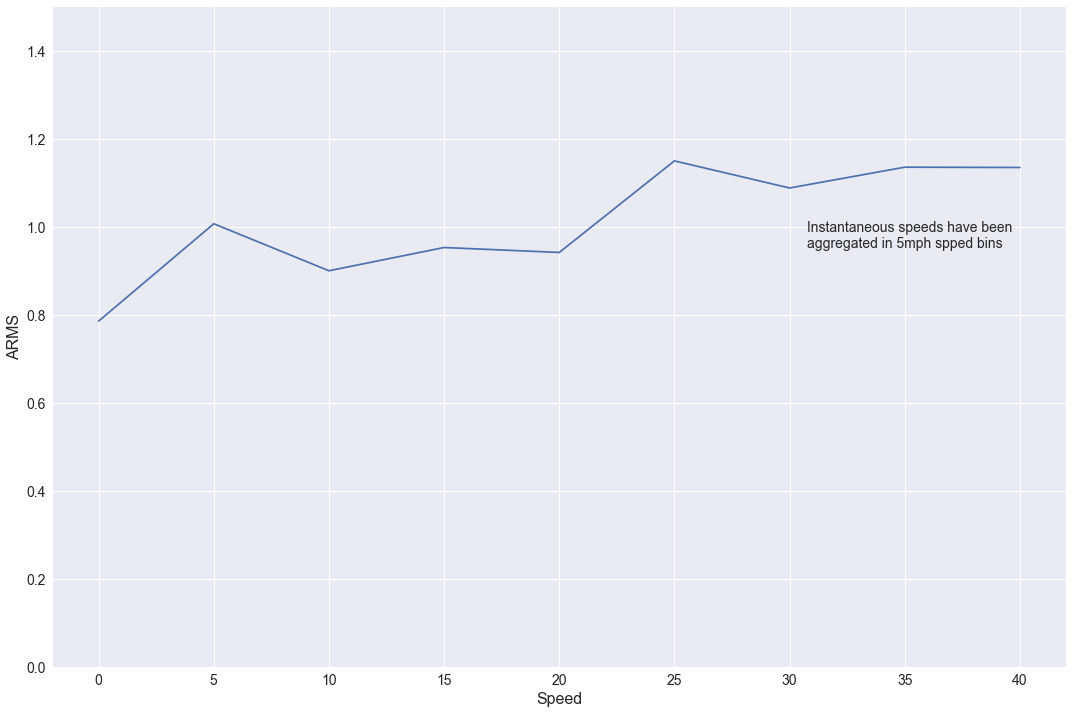

In [55]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(arms[arms.speedbin <=40].speedbin, arms[arms.speedbin <=40].arms)
ax.set_ylim([0,1.5])
ax.set_ylabel('ARMS', fontsize=16)
ax.set_xlabel('Speed', fontsize=16)

fig.tight_layout()
fig.text(0.75, 0.65, "Instantaneous speeds have been \naggregated in 5mph spped bins", fontsize=14)

fig.savefig(os.path.join(OUT_FOLDER, "ngRe ARMS.png"))


### Standard Deviation of Acceleration 

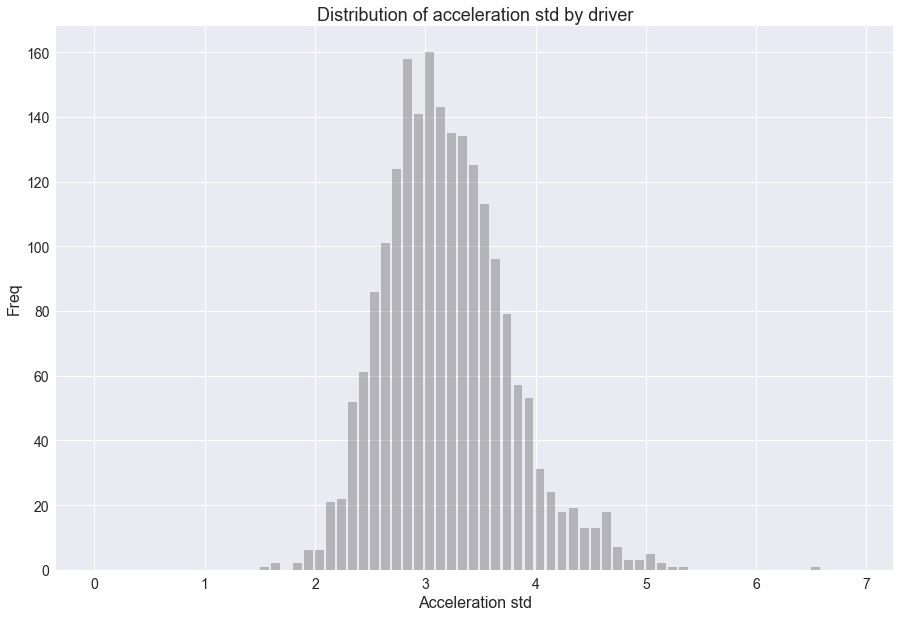

In [56]:
ng_veh_acc_std = (ng.groupby('VehID')['vehAcceleration'].std()
                  .to_frame().reset_index()
                  .rename(columns={'vehAcceleration':'accel_std'}) )
ng_veh_acc_std.head()

fig, ax = plt.subplots(figsize=(15,10))
ax.hist(ng_veh_acc_std.accel_std, bins=np.arange(0,7,0.1), alpha=0.5, 
        color='grey',width=0.08)
ax.set_title('Distribution of acceleration std by driver', fontsize=18)
ax.set_xlabel('Acceleration std', fontsize=16)
ax.set_ylabel("Freq", fontsize=16)

# Lane Changing

In [57]:
ng = ng.sort_values(['VehID', 'time'])
ng.index = np.arange(ng.shape[0])

ng['laneChange'] = 0
ng.loc[ng.lane != ng.lane.shift(-1), 'laneChange'] = 1
ng.loc[ng.VehID != ng.VehID.shift(-1), 'laneChange'] = 0

ng['laneChangeA'] = 0
ng.loc[ng.lane != ng.lane.shift(1), 'laneChangeA'] = 1
ng.loc[ng.VehID != ng.VehID.shift(1), 'laneChangeA'] = 0

In [58]:
tmp = ng.groupby('lane')['laneChange'].sum().to_frame().reset_index()
tmp.rename(columns={'laneChange':"NumOfVehiclesLeavingLane"}, inplace=True)
tmp['NumOfVehiclesEnteringLane'] = ng.groupby('lane')['laneChangeA'].sum().to_frame().reset_index()['laneChangeA']
tmp

lane  NumOfVehiclesLeavingLane  NumOfVehiclesEnteringLane
0     1                        13                         15
1     2                        36                         88
2     3                        99                        124
3     4                       130                        143
4     5                       162                        181
5     6                       165                        240
6     7                       198                          8
7   999                         1                          5

In [59]:
LCR_TIME_BIN = 60 # seconds 
LCR_SPACE_BIN = 100 # in feet


ng['spacebin'] = np.array(ng.locY // LCR_SPACE_BIN, np.int)
ng['timebin'] = pd.to_datetime(((ng.time.astype(np.int64) // 
                                 (LCR_TIME_BIN * 1e9) ) * (LCR_TIME_BIN * 1e9) ))


In [60]:
ng_laneChangeRates = (ng.groupby(['lane', 'spacebin', 'timebin'])['laneChange']
                   .sum()
                  )

ng_laneChangeRates = ng_laneChangeRates * (3600 / LCR_TIME_BIN) * (5280 / LCR_SPACE_BIN) 

ng_laneChangeRates = ng_laneChangeRates.to_frame().reset_index()
ng_laneChangeRates = ng_laneChangeRates.rename(columns={'lane':'laneIndex'})

mi = pd.MultiIndex.from_product([sorted(ng.lane.unique()), 
                                 sorted(ng.spacebin.unique()), 
                                 ng.timebin.unique()], 
                                 names=['laneIndex', 'spacebin', 'timebin'])

mi = pd.DataFrame(index=mi)
mi.reset_index(inplace=True)

ng_laneChangeRates = ng_laneChangeRates.merge(mi, on=['laneIndex', 'spacebin', 'timebin'], how='right')

ng_laneChangeRates = ng_laneChangeRates.set_index(['laneIndex', 'spacebin', 'timebin']).unstack()

ng_laneChangeRates.head()

laneChange                      \
timebin            2005-04-13 16:00:00 2005-04-13 16:01:00   
laneIndex spacebin                                           
1         1                        0.0                 0.0   
          2                        0.0                 0.0   
          3                        0.0                 0.0   
          4                     3168.0                 0.0   
          5                     3168.0                 0.0   

                                                            \
timebin            2005-04-13 16:02:00 2005-04-13 16:03:00   
laneIndex spacebin                                           
1         1                        0.0                 0.0   
          2                        0.0                 0.0   
          3                        0.0                 0.0   
          4                        0.0                 0.0   
          5                        0.0                 0.0   

                                                            \
timebin            2005-04-13 16:04:00 2005-04-13 16:05:00   
laneIndex spacebin                                           
1         1                        0.0                 0.0   
          2                        0.0              3168.0   
          3                        0.0                 0.0   
          4                        0.0                 0.0   
          5                        0.0                 0.0   

                                                            \
timebin            2005-04-13 16:06:00 2005-04-13 16:07:00   
laneIndex spacebin                                           
1         1                        0.0                 0.0   
          2                        0.0                 0.0   
          3                        0.0                 0.0   
          4                     3168.0                 0.0   
          5                        0.0                 0.0   

                                                            \
timebin            2005-04-13 16:08:00 2005-04-13 16:09:00   
laneIndex spacebin                                           
1         1                        0.0                 0.0   
          2                        0.0                 0.0   
          3                        0.0                 0.0   
          4                        0.0                 0.0   
          5                        0.0                 0.0   

                                                            \
timebin            2005-04-13 16:10:00 2005-04-13 16:11:00   
laneIndex spacebin                                           
1         1                        0.0                 0.0   
          2                        0.0                 0.0   
          3                        0.0              3168.0   
          4                        0.0              3168.0   
          5                        0.0                 0.0   

                                                            \
timebin            2005-04-13 16:12:00 2005-04-13 16:13:00   
laneIndex spacebin                                           
1         1                        0.0              3168.0   
          2                        0.0                 0.0   
          3                        0.0                 0.0   
          4                        0.0                 0.0   
          5                        0.0                 0.0   

                                                                                
timebin            2005-04-13 16:14:00 2005-04-13 16:15:00 2005-04-13 16:16:00  
laneIndex spacebin                                                              
1         1                        0.0                 0.0                 NaN  
          2                        0.0                 0.0                 NaN  
          3                        0.0                 0.0                 NaN  
          4                        0.0                 0.0     

In [61]:
ng_laneChangeRates.max().max()

47520.0

C:\Anaconda\envs\py34\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


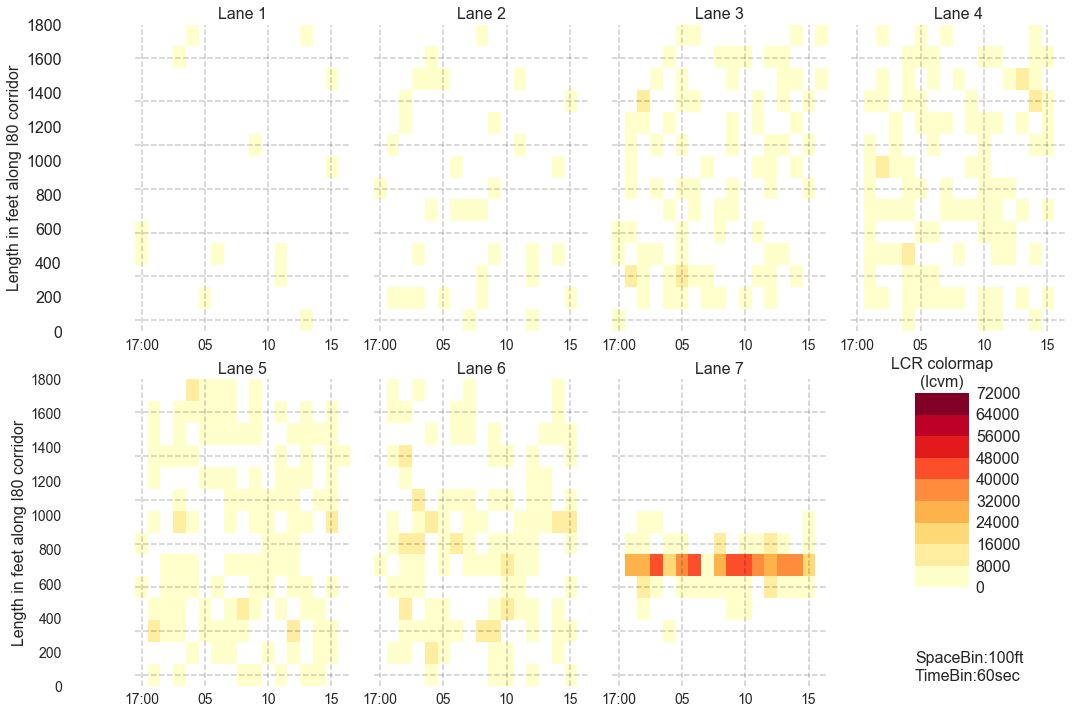

In [62]:
#fig = plt.figure(figsize=(15,10))
fig = plt.figure(figsize=(15,10))

gs = mpl.gridspec.GridSpec(2, 5, width_ratios=[0.2, 1, 1, 1, 1])

#bounds = list(np.linspace(0, ng_laneChangeRates.max().max(), 10)) 
MAX_LCR = 72000
bounds = list(np.linspace(0, MAX_LCR, 10))
bounds.insert(0, -10)
bounds[1] = 0.1

colors = ['white', '#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
cmap = mpl.colors.ListedColormap(colors) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

assert len(bounds) == len(colors) + 1

cb = None 

ax = None
for i in range(1, 8):
    
    j = (i-1) % 4
    k = (i-1) // 4
    ax = plt.subplot(gs[k,j+1])
    
    data = ng_laneChangeRates.loc[i].values
    nan_mask = np.isnan(data)
    tmp = data.copy()
    tmp[nan_mask] = -1
    tmp

    cb = ax.imshow(tmp, cmap=cmap, norm=norm, origin='lower', aspect='auto')
    #cb = ax.imshow(tmp, origin='lower')
    
    ax.set_xticklabels(['', '17:00', '05', '10', '15', ''])
    #x_ticklabels = ["", "5:00", "5", "10", "15", '20', '25', '30']
    #ax.set_xticklabels(x_ticklabels, fontsize=15)

    ax.set_yticklabels([])
    
    ax.grid(True, color='black', ls='dashed', lw=0.3)
    
    ax.set_title("Lane %d" % i, fontsize=16)
    
cmax = fig.add_axes([0.85, 0.15, 0.05, 0.3])

fig.colorbar(cb, cax=cmax, norm=norm, boundaries=bounds, ticks=bounds)
cmax.set_title("LCR colormap\n(lcvm)", fontsize=16)

cm_labels = ["%d" % i for i in list(map(int, bounds))]
cm_labels[0] = "" 
cmax.set_yticklabels(cm_labels, fontsize=16)


ax1 = plt.subplot(gs[0,0]) #, sharey=plt.subplot(gs[0,1]))
ax2 = plt.subplot(gs[1,0]) #, sharey=plt.subplot(gs[1,1]))

ytick_labels = [i for i in range(0,2000,200)]
ax1.set_yticks(ytick_labels)
ax1.set_yticklabels(ytick_labels, fontsize=16)
ax1.set_xticklabels([])
ax1.grid(False)
ax1.set_ylabel("Length in feet along I80 corridor", fontsize=16)
ax1.set_facecolor('white')

ax2.set_yticks(ytick_labels)
ax2.set_yticklabels(ytick_labels, fontsize=14)
ax2.set_xticklabels([])
ax2.grid(False)
ax2.set_ylabel("Length in feet along I80 corridor", fontsize=16)
ax2.set_facecolor('white')

fig.text(0.85, 0.05, "SpaceBin:%dft\nTimeBin:%dsec" % 
          (LCR_SPACE_BIN, LCR_TIME_BIN), fontsize=16)

fig.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, 'ngRe LCR.png'))

# Safety 

In [63]:
vehLength = (ng.groupby(['VehID'])['vehLength']
             .first().to_frame().reset_index())
vehLength.head()

VehID  vehLength
0      1  14.301509
1      2  15.301509
2      4  13.401575
3      5  14.401575
4      7  17.801837

In [64]:
# ng1s.head()

# ng1s = ng1s.sort_values(['lane', 'time', 'locY'],
#                         ascending=[True, True, True])
# ng1s.index = np.arange(ng1s.shape[0])

# ng1s['precedingVeh'] = ng.VehID.shift(-1)
# ng1s.loc[ng1s.lane  != ng1s.lane.shift(-1), 'precedingVeh'] =  np.nan 
# ng1s.loc[ng1s.time  != ng1s.time.shift(-1), 'precedingVeh'] =  np.nan 

# ng1s['followingVeh'] = ng1s.VehID.shift(1)
# ng1s.loc[ng1s.lane  != ng1s.lane.shift(1), 'followingVeh'] =  np.nan 
# ng1s.loc[ng1s.time  != ng1s.time.shift(1), 'followingVeh'] =  np.nan 

# ng1s['spacing'] = ng1s.locY.shift(-1) - ng1s.locY
# ng1s.loc[ng1s.lane  != ng1s.lane.shift(-1), 'spacing'] =  np.nan 
# ng1s.loc[ng1s.time  != ng1s.time.shift(-1), 'spacing'] =  np.nan 


# ng1s = ng1s.merge(vehLength.rename(columns={'VehID':'precedingVeh', 
#                           'vehLength':'precedingVehLength'}),
#            on=['precedingVeh'], how='left')

# ng1s['gap'] = ng1s.spacing - ng1s.precedingVehLength

# describe(ng1s['gap'])

# ng1s['TTCs'] = ng1s.gap_pos / (ng1s.speedmph.shift(-1) - ng1s.speedmph) * (5280 / 3600)

# ng1s.loc[ng1s.TTCs < 0, 'TTCs'] = np.nan
# ng1s.loc[ng1s.TTCs == np.inf, 'TTCs'] = np.nan

In [65]:
ng = ng.merge(vehLength.rename(columns={'VehID':'precedingVeh', 
                          'vehLength':'precedingVehLength'}),
           on=['precedingVeh'], how='left')

ng = ng.sort_values(['lane', 'time', 'locY'],
                        ascending=[True, True, True])
ng.index = np.arange(ng.shape[0])

ng['spacing']    = ng.locY.shift(-1) - ng.locY
ng.loc[ng.lane  != ng.lane.shift(-1), 'spacing'] =  np.nan 
ng.loc[ng.time  != ng.time.shift(-1), 'spacing'] =  np.nan 

ng['gap'] = ng['spacing'] - ng.precedingVehLength

In [66]:
describe(ng.gap)

stats
count  1055801.0
NA       66729.0
mean        50.5
std         42.2
min          0.0
ptc5        13.2
pct25       26.3
pct50       40.0
ptc75       61.3
pct95      121.3
max       1268.1

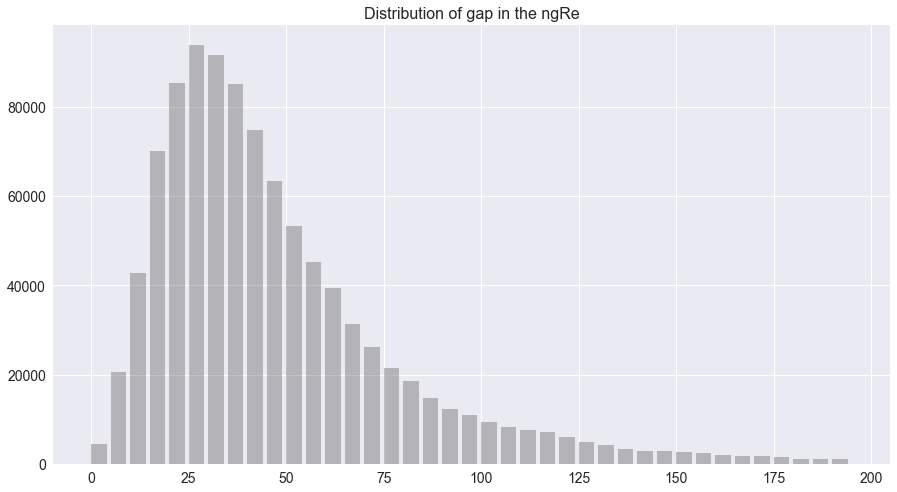

In [67]:
fig = plt.figure(figsize=(15,10))

gs = mpl.gridspec.GridSpec(2, 1,height_ratios=[8, 1])

ax1 = plt.subplot(gs[0,0])

#bins, hist = np.histogram(ng.gap.dropna(), ns=np.arange(0,200,5))

ax1.hist(ng.gap.dropna(), bins=np.arange(0,200,5), 
        width=4, color='grey', alpha=0.5)

ax1.set_title("Distribution of gap in the ngRe", fontsize=16)


In [68]:
# fig = plt.figure(figsize=(15,10))

# gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[8, 0.25])

# ax1 = plt.subplot(gs[0,0])
# ax2 = plt.subplot(gs[0,1])

# cm = ax1.hexbin(ng[ng.gap.notnull()].vehSpeed, 
#            ng[ng.gap.notnull()].gap,
#             cmap=plt.cm.bone_r, bins='log')

# fig.colorbar(cm, cax=ax2)
# ax1.set_facecolor('white')

# ax1.set_title("Distribution of gap in the ngRe", fontsize=16)

In [69]:
ng['TTCs'] = ng.gap / (ng.vehSpeed.shift(-1) - ng.vehSpeed) * (5280 / 3600)

ng.loc[ng.TTCs < 0, 'TTCs'] = np.nan
ng.loc[ng.TTCs == np.inf, 'TTCs'] = np.nan

In [70]:
hist, bins = np.histogram(ng.TTCs.dropna(), bins=np.arange(0, 15, 1), range=[0,15])
ng_TTC_freq = pd.DataFrame(index=bins[:-1], data=hist, columns=['freq'])
labels = ["%d <= TTC < %d" % (i, i+1) for i in bins[:-1]]
ng_TTC_freq.index = labels
ng_TTC_freq['ngRe_Percentage'] = ng_TTC_freq['freq'] / ng.shape[0] * 100
ng_TTC_freq.to_clipboard()
ng_TTC_freq.to_csv(os.path.join(OUT_FOLDER, "ngRe TTCs.csv"))
ng_TTC_freq

freq  ngRe_Percentage
0 <= TTC < 1       65         0.006156
1 <= TTC < 2      412         0.039023
2 <= TTC < 3     1090         0.103239
3 <= TTC < 4     2001         0.189524
4 <= TTC < 5     3087         0.292385
5 <= TTC < 6     4766         0.451411
6 <= TTC < 7     6325         0.599071
7 <= TTC < 8     7202         0.682136
8 <= TTC < 9     8570         0.811706
9 <= TTC < 10    9592         0.908505
10 <= TTC < 11  10320         0.977457
11 <= TTC < 12  10701         1.013543
12 <= TTC < 13  10560         1.000188
13 <= TTC < 14  11053         1.046883

In [71]:
ng_TTC_freq.ngRe_Percentage.sum()

8.1212273903889081

## Safety events 

In [72]:
ng[ng.gap <= 0].shape

(0, 19)

In [73]:
ng[(ng.TTCs < 2) & (ng.vehAcceleration < 16)].shape

(475, 19)

In [74]:
ng[ng.TTCs < 2.4].shape

(812, 19)

In [75]:
safety_events = pd.DataFrame(index=['collisions', 'safety events', 'warnings'],
                   data={'numOfEvents':[0, 475, 812]})

safety_events.to_csv(os.path.join(OUT_FOLDER, "ngRe safety events.csv"))
safety_events

numOfEvents
collisions               0
safety events          475
warnings               812

## Lane Change Urgency 

In [76]:
ng = ng.sort_values(['VehID', 'time'])
ng.index = np.arange(ng.shape[0])

ng['laneChange'] = 0
ng.loc[ng.lane  != ng.lane.shift(-1), 'laneChange'] = 1
ng.loc[ng.VehID != ng.VehID.shift(-1), 'laneChange'] = 0 

ng['laneChangeA'] = 0
ng.loc[ng.lane.shift(1)  != ng.lane, 'laneChangeA'] = 1
ng.loc[ng.VehID.shift(1) != ng.VehID, 'laneChangeA'] = 0 

In [77]:
laneChangesPerLane = (ng.groupby('lane')[['laneChange', 'laneChangeA']].sum()
   .rename(columns={'laneChange':'numberOfVehiclesLeaving',
                    'laneChangeA':'numberOfVehiclesEntering'}))


laneChangesPerLane.to_csv(os.path.join(OUT_FOLDER, "ngRe laneChangesPerLane.csv"))
laneChangesPerLane

numberOfVehiclesLeaving  numberOfVehiclesEntering
lane                                                   
1                          13                        15
2                          36                        88
3                          99                       124
4                         130                       143
5                         162                       181
6                         165                       240
7                         198                         8
999                         1                         5

In [78]:
hist, bins = np.histogram(ng[ng.laneChange == 1]['TTCs'].dropna(), bins=[0, 3, 5.5, 1000000], range=[0, 1000000])

ng_LCU = pd.DataFrame(index=bins[:-1], data=hist, columns=['freq'])
ng_LCU.index = ['Forced', 'Urgent', 'Non-urgent']

ng_LCU['percentage'] = ng_LCU.freq / ng_LCU.freq.sum() * 100

ng_LCU.to_csv(os.path.join(OUT_FOLDER, "ngRe LCU.csv"))

ng_LCU

freq  percentage
Forced         0    0.000000
Urgent         2    1.041667
Non-urgent   190   98.958333

## Lane Change Severity 

In [79]:
ng = ng.sort_values(['lane', 'time', 'locY'])
ng.index = np.arange(ng.shape[0])

ng['follower_distance'] = ng.locY - ng.locY.shift(1)
ng['follower_speed']    = ng.vehSpeed.shift(1)

ng.loc[ng.time != ng.time.shift(1), 'follower_distance'] = np.nan
ng.loc[ng.lane != ng.lane.shift(1), 'follower_distance'] = np.nan
ng.loc[ng.time != ng.time.shift(1), 'speed'] = np.nan
ng.loc[ng.lane != ng.lane.shift(1), 'speed'] = np.nan

ng['Tr'] = (ng.follower_distance - 30) / (ng.follower_speed * 5260/3600)
ng.loc[ng.laneChange != 1, 'Tr'] = np.nan
ng.loc[ng.follower_distance <= 30, 'Tr'] = np.nan
ng.loc[ng.Tr == np.inf, 'Tr'] = np.nan


In [80]:
hist, bins = np.histogram(ng.Tr.dropna(), bins=[0, 1, 3, 5, 1000000])

ng_LCS = pd.DataFrame(index=bins[:-1], data=hist, columns=['freq'])
ng_LCS.index = ['4', '3', '2', '1']

ng_LCS['percentage'] = ng_LCS.freq / ng.laneChange.sum() * 100

ng_LCS.to_csv(os.path.join(OUT_FOLDER, "ngRe LCS.csv"))

ng_LCS.sort_index()

freq  percentage
1    33    4.104478
2    60    7.462687
3   317   39.427861
4   266   33.084577